In [1]:
pip install plotly --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 88.7 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


In [2]:
!pip install statsmodels

In [3]:
!pip install openpyxl

In [4]:
pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0


In [5]:
!pip install xgboost

In [6]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import scipy
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
import math
from sklearn.preprocessing import RobustScaler
import joblib
from scipy.stats import skew
from google.colab import drive
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics
import statistics
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.subplots as sp
from plotly.colors import qualitative
%matplotlib inline
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

# **Carga de dataset**

In [95]:
# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Load the CSV file
file_path = '/content/dataset__.xlsx'  # Update this path to your CSV file
df = pd.read_excel(file_path, parse_dates=['Tiempo'])

df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Tiempo                         26280 non-null  datetime64[ns]
 1   Corriente (A)                  26280 non-null  object        
 2   Radiación (W / m2)             26280 non-null  float64       
 3   Temperatura a 2 m (°C)         26280 non-null  float64       
 4   Precipitación (mm / hr)        26280 non-null  float64       
 5   Humedad relativa a 2 m (%)     26280 non-null  float64       
 6   Velocidad Viento a 10 m
(m/s)  26280 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 1.4+ MB


In [96]:
print("Fecha inicio análisis: ", df['Tiempo'].min())
print("Fecha fin análisis: ", df['Tiempo'].max())

Fecha inicio análisis:  2021-01-01 00:00:00
Fecha fin análisis:  2023-12-31 23:00:00


# **Preprocesamiento**

## Detección de valores no númericos

In [97]:
# Función para identificar si el valor es numérico o fecha
def is_not_numeric_or_date(value):
    # Si el valor es NaT (not a time) o NaN, no es fecha ni numérico
    if pd.isna(value):
        return True
    # Si es un número o una fecha válida, no es lo que buscamos
    if isinstance(value, (int, float, pd.Timestamp)):
        return False
    return True

# Aplicar la función a todas las columnas del DataFrame
non_numeric_or_date_mask = df.map(is_not_numeric_or_date)

In [98]:
rows_with_non_numeric_or_date = df[non_numeric_or_date_mask.any(axis=1)]
rows_with_non_numeric_or_date.head(5)

Tiempo Corriente (A)  Radiación (W / m2)  \
2001 2021-03-25 09:00:00   Not Connect              519.27   
2002 2021-03-25 10:00:00   Not Connect              675.30   
3972 2021-06-15 12:00:00   Not Connect              703.99   
4142 2021-06-22 14:00:00           Bad              624.12   
4187 2021-06-24 11:00:00           Bad              691.06   

      Temperatura a 2 m (°C)  Precipitación (mm / hr)  \
2001                   23.41                     0.00   
2002                   24.94                     0.00   
3972                   28.17                     0.19   
4142                   28.68                     0.00   
4187                   28.65                     0.00   

      Humedad relativa a 2 m (%)  Velocidad Viento a 10 m\n(m/s)  
2001                       13.85                            0.91  
2002                       13.79                            1.39  
3972                       14.10                            2.12  
4142                       12.33                            0.98  
4187                       11.96                            1.77

In [99]:
# Reemplazar los valores no numéricos ni fechas por NaN
rows_with_non_numeric_or_date_replaced = rows_with_non_numeric_or_date.map(lambda x: np.nan if is_not_numeric_or_date(x) else x)
# Mostrar el DataFrame con los valores reemplazados por NaN
rows_with_non_numeric_or_date_replaced.head(5)

Tiempo  Corriente (A)  Radiación (W / m2)  \
2001 2021-03-25 09:00:00            NaN              519.27   
2002 2021-03-25 10:00:00            NaN              675.30   
3972 2021-06-15 12:00:00            NaN              703.99   
4142 2021-06-22 14:00:00            NaN              624.12   
4187 2021-06-24 11:00:00            NaN              691.06   

      Temperatura a 2 m (°C)  Precipitación (mm / hr)  \
2001                   23.41                     0.00   
2002                   24.94                     0.00   
3972                   28.17                     0.19   
4142                   28.68                     0.00   
4187                   28.65                     0.00   

      Humedad relativa a 2 m (%)  Velocidad Viento a 10 m\n(m/s)  
2001                       13.85                            0.91  
2002                       13.79                            1.39  
3972                       14.10                            2.12  
4142                       12.33                            0.98  
4187                       11.96                            1.77

In [100]:
# Reemplazar las filas Object con valores NaN
df.iloc[rows_with_non_numeric_or_date_replaced.index]=rows_with_non_numeric_or_date_replaced

In [101]:
#Validar cantidad de valores null
df.isnull().sum()

Tiempo                              0
Corriente (A)                     213
Radiación (W / m2)                  0
Temperatura a 2 m (°C)              0
Precipitación (mm / hr)             0
Humedad relativa a 2 m (%)          0
Velocidad Viento a 10 m\n(m/s)      0
dtype: int64

In [102]:
df['Corriente (A)'] = pd.to_numeric(df['Corriente (A)'], errors='coerce')

##Análisis exploratorio de datos

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Tiempo                         26280 non-null  datetime64[ns]
 1   Corriente (A)                  26067 non-null  float64       
 2   Radiación (W / m2)             26280 non-null  float64       
 3   Temperatura a 2 m (°C)         26280 non-null  float64       
 4   Precipitación (mm / hr)        26280 non-null  float64       
 5   Humedad relativa a 2 m (%)     26280 non-null  float64       
 6   Velocidad Viento a 10 m
(m/s)  26280 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 1.4 MB


In [104]:
df.iloc[:,1:].describe()

Corriente (A)  Radiación (W / m2)  Temperatura a 2 m (°C)  \
count   26067.000000        26280.000000            26280.000000   
mean       10.907262          212.607583               23.416988   
std         5.592521          281.572082                3.597973   
min         0.000000            0.000000               15.220000   
25%         9.050138            0.000000               20.580000   
50%        12.050184            5.105000               22.480000   
75%        14.050215          442.247500               25.780000   
max       171.052612          984.450000               36.260000   

       Precipitación (mm / hr)  Humedad relativa a 2 m (%)  \
count             26280.000000                26280.000000   
mean                  0.163410                   15.111830   
std                   0.307153                    1.669595   
min                   0.000000                    8.730000   
25%                   0.000000                   14.160000   
50%                   0.050000                   15.320000   
75%                   0.190000                   16.240000   
max                   7.070000                   20.510000   

       Velocidad Viento a 10 m\n(m/s)  
count                    26280.000000  
mean                         1.090214  
std                          0.633576  
min                          0.000000  
25%                          0.620000  
50%                          0.960000  
75%                          1.450000  
max                          3.740000

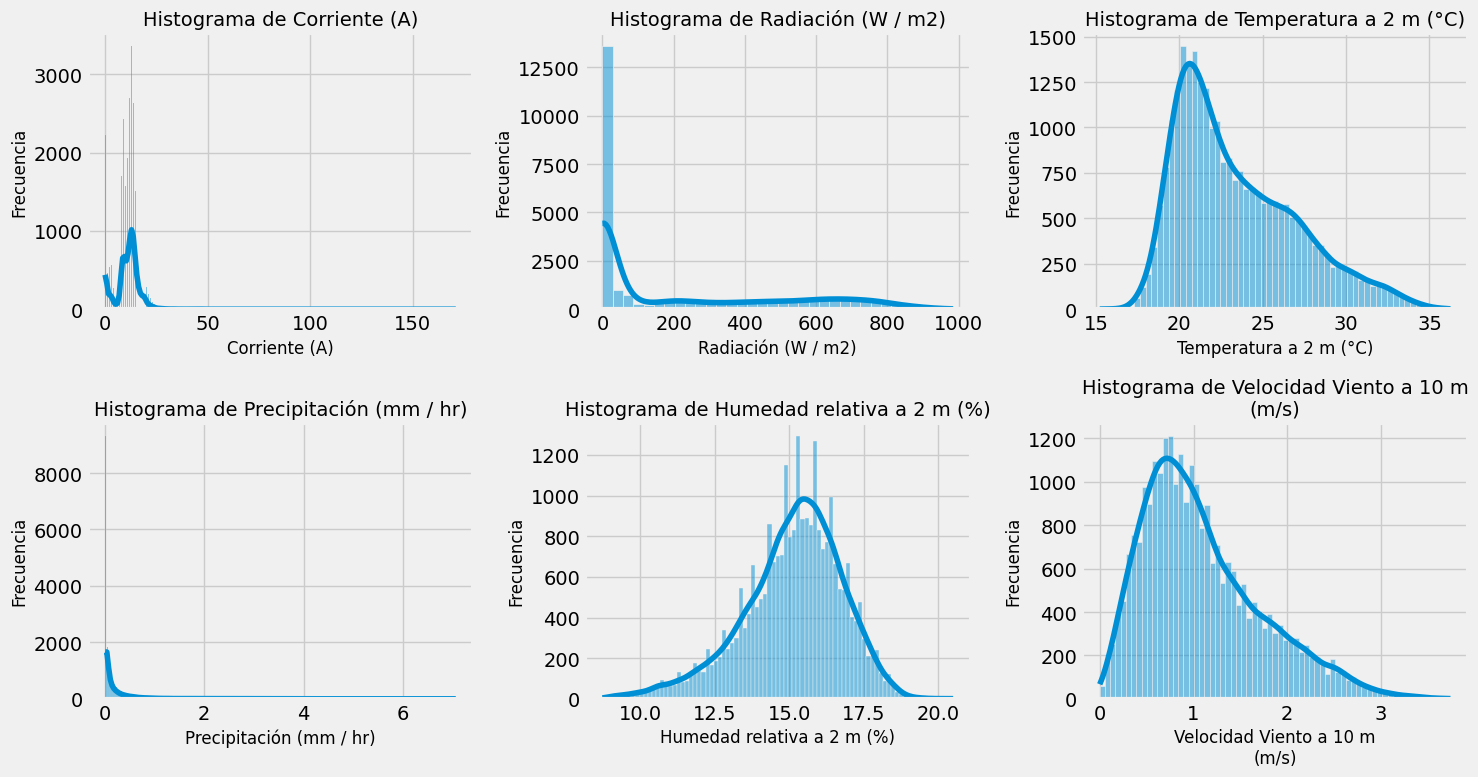

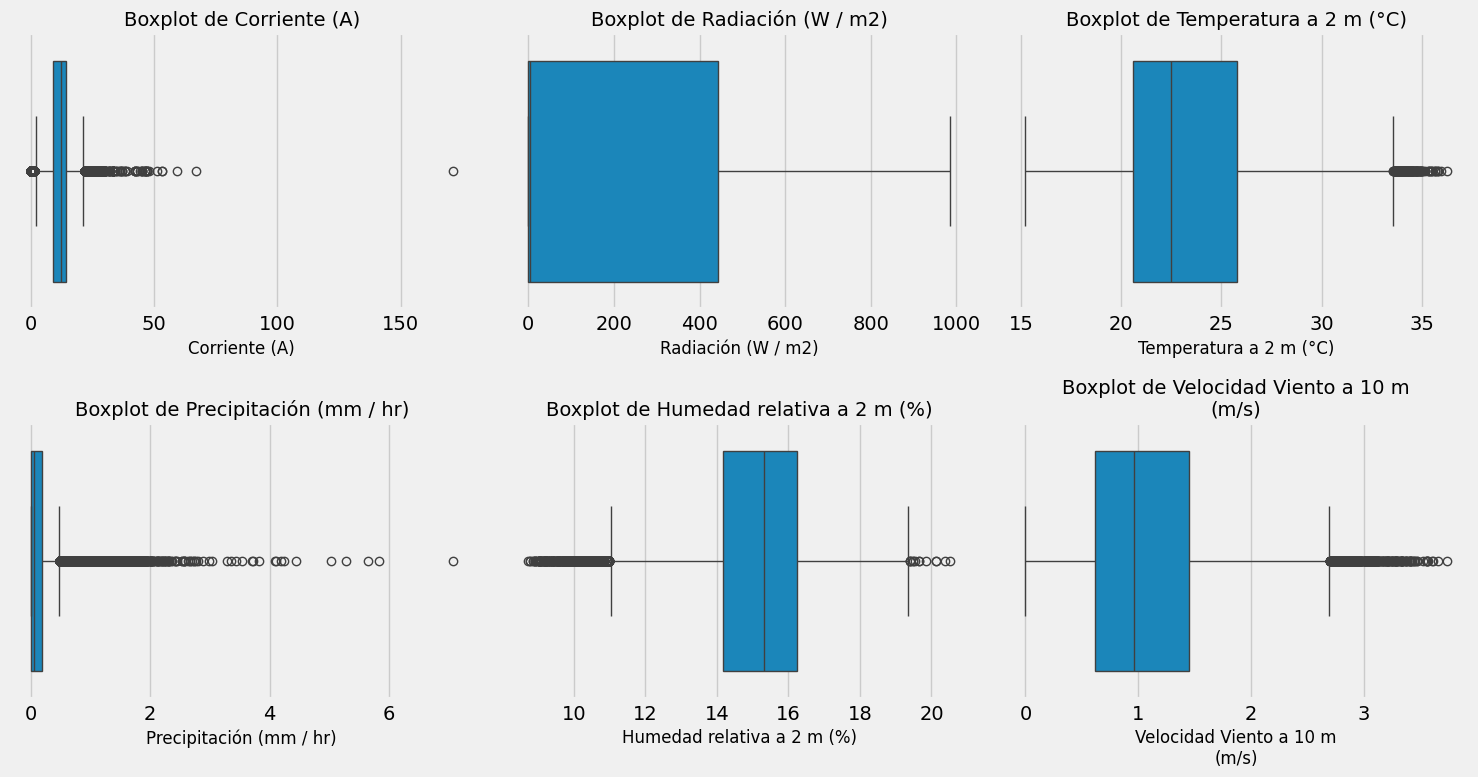

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Obtener las columnas del DataFrame excluyendo la primera columna
columns = df.iloc[:, 1:].columns

# Definir el número de gráficos por fila
num_plots_per_row = 3

# Calcular el número de filas necesarias
num_rows = math.ceil(len(columns) / num_plots_per_row)

# Figura para histogramas
fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(15, num_rows * 4))
axes = axes.flatten()

for i, column in enumerate(columns):
    sns.histplot(data=df, x=column, ax=axes[i], kde=True)
    axes[i].set_title(f'Histograma de {column}', fontsize=14)
    axes[i].set_xlabel(column, fontsize=12) # Ajusta el tamaño de letra del eje X
    axes[i].set_ylabel('Frecuencia', fontsize=12) # Ajusta el tamaño de letra del eje Y

# Remover cualquier subplot extra
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Figura para boxplots
fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(15, num_rows * 4))
axes = axes.flatten()

for i, column in enumerate(columns):
    sns.boxplot(data=df, x=column, ax=axes[i])
    axes[i].set_title(f'Boxplot de {column}', fontsize=14)
    axes[i].set_xlabel(column, fontsize=12) # Ajusta el tamaño de letra del eje X
    axes[i].set_ylabel('', fontsize=12)  # Ajusta el tamaño de letra del eje Y (o déjalo vacío)

# Remover cualquier subplot extra
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [106]:
# Preparar datos y cambiar nombre de columna
df1 = df[['Tiempo','Corriente (A)']].copy()
df1['Año'] = df1['Tiempo'].dt.year
df_filtered = df1[df1['Año'].isin([2021, 2022, 2023])]

# Crear figura con subplots independientes
fig = sp.make_subplots(rows=3, cols=1,
                      subplot_titles=[f'Año {year}' for year in [2021, 2022, 2023]],
                      vertical_spacing=0.1)

# Configurar colores y añadir trazas
colors = qualitative.Dark24
for i, year in enumerate([2021, 2022, 2023], 1):
    df_year = df_filtered[df_filtered['Año'] == year]

    fig.add_trace(
        px.line(df_year,
                x='Tiempo',
                y='Corriente (A)',
                color_discrete_sequence=[colors[i-1]]
               ).data[0],
        row=i,
        col=1
    )

    # Personalizar layout individual para cada año
    fig.update_xaxes(
        title_text="Fecha" if i == 3 else None,
        tickformat="%b-%d-%Y",
        row=i,
        col=1
    )

    fig.update_yaxes(
        title_text='Corriente (A)' if i == 2 else None,
        range=[0, df_year['Corriente (A)'].max() * 1.1],
        row=i,
        col=1
    )

# Configuración general del layout
fig.update_layout(
    title_text='<b>Corriente (A)</b>',
    title_x=0.5,
    title_font=dict(size=24, color='black'),
    height=900,
    width=1200,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    margin=dict(l=60, r=30, b=60, t=100)
)

# Ajustar títulos de subplots
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=14, color='#333333')

fig.show()

In [107]:
variables_Sesgo = ['Corriente (A)', 'Radiación (W / m2)',
       'Temperatura a 2 m (°C)', 'Precipitación (mm / hr)',
       'Humedad relativa a 2 m (%)', 'Velocidad Viento a 10 m\n(m/s)']

# Calcular el sesgo de las variables especificadas
skewness_values = {var: skew(df[var], bias=False) for var in variables_Sesgo}

# Mostrar los resultados
print("Sesgo (skewness) de las variables seleccionadas:")
for var, skewness in skewness_values.items():
    print(f"{var}: {skewness}")

Sesgo (skewness) de las variables seleccionadas:
Corriente (A): nan
Radiación (W / m2): 0.9617770894781461
Temperatura a 2 m (°C): 0.8077815395591605
Precipitación (mm / hr): 4.7761279157150005
Humedad relativa a 2 m (%): -0.6303070398681682
Velocidad Viento a 10 m
(m/s): 0.872642554279679


In [108]:
df.isnull().sum()

Tiempo                              0
Corriente (A)                     213
Radiación (W / m2)                  0
Temperatura a 2 m (°C)              0
Precipitación (mm / hr)             0
Humedad relativa a 2 m (%)          0
Velocidad Viento a 10 m\n(m/s)      0
dtype: int64

##Manejo de valores faltantes, atípicos y estandarización

In [109]:
df3 = df.iloc[:,1:]

# Suponiendo que `df` es tu DataFrame
percentile_low = 0.01  # Percentil 1%
percentile_high = 0.99  # Percentil 99%

# Identificar puntos fuera del rango [1%, 99%] para cada feature
outliers_count = 0
total_data_points = len(df3) * len(df3.columns)  # Total de puntos en el DataFrame

for col in df.select_dtypes(include=['float64', 'int64']).columns:  # Solo columnas numéricas
    lower_bound = df3[col].quantile(percentile_low)
    upper_bound = df3[col].quantile(percentile_high)
    # Contar valores fuera del rango
    outliers_count += df3[(df[col] < lower_bound) | (df3[col] > upper_bound)].shape[0]

# Calcular el porcentaje estimado de puntos atípicos
contamination_estimate = outliers_count / total_data_points
print(f"Estimación inicial de contaminación: {contamination_estimate:.4f}")

Estimación inicial de contaminación: 0.0142


In [110]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
import joblib

def detect_outliers(df, method='iqr', threshold=3, contamination=0.005):
    """
    Detecta valores atípicos utilizando el método especificado.
    """
    # Convertir columnas a numéricas y seleccionar solo numéricas
    df_numeric = df.apply(pd.to_numeric, errors='coerce')
    numeric_cols = df_numeric.select_dtypes(include=np.number).columns
    df_numeric = df_numeric[numeric_cols]

    outliers = pd.DataFrame(False, index=df.index, columns=df.columns)

    if method == 'zscore':
        zscores = np.abs(stats.zscore(df_numeric))
        outliers_numeric = zscores > threshold
        outliers.loc[:, numeric_cols] = outliers_numeric
    elif method == 'iqr':
        Q1 = df_numeric.quantile(0.05)
        Q3 = df_numeric.quantile(0.95)
        IQR = Q3 - Q1
        outliers_numeric = (df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))
        outliers.loc[:, numeric_cols] = outliers_numeric
    elif method == 'isolation_forest':
        iso = IsolationForest(contamination=contamination, random_state=42)
        row_outliers = iso.fit_predict(df_numeric) == -1
        outliers.loc[row_outliers, :] = True
    else:
        raise ValueError(f"Método no válido: {method}")

    return outliers

def handle_outliers(df, method='winsorize', outlier_method='iqr', lower_quant=0.01, upper_quant=0.99):
    """
    Maneja los valores atípicos utilizando el método especificado.
    """
    outliers = detect_outliers(df, method=outlier_method)

    if method == 'winsorize':
        for col in df.select_dtypes(include=np.number).columns:
            low = df[col].quantile(lower_quant)
            high = df[col].quantile(upper_quant)
            df[col] = df[col].clip(low, high)
    elif method == 'remove':
        df = df[~outliers.any(axis=1)]

    return df

def normalize_data(df, method='robust'):
    """
    Normaliza o estandariza los datos.
    """
    scaler = StandardScaler() if method == 'standard' else RobustScaler()
    scaled_data = scaler.fit_transform(df)
    joblib.dump(scaler, f'{method}_scaler.pkl')  # Nombre de archivo dinámico
    return pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

def impute_missing_values(df, method='knn', n_neighbors=20):
    """
    Imputa valores faltantes.
    """
    if method == 'knn':
        imputer = KNNImputer(n_neighbors=n_neighbors)
    return pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)

def preprocess_data(df,
                    outlier_method='winsorize',
                    scaling_method='robust',
                    imputation_method='knn'):
    """
    Flujo de preprocesamiento corregido:
    1. Imputación
    2. Manejo de outliers
    3. Normalización
    """
    # Imputación inicial para datos faltantes
    df_imputed = impute_missing_values(df, method=imputation_method)

    # Manejo de outliers
    df_cleaned = handle_outliers(df_imputed, method=outlier_method)

    # Normalización
    df_scaled = normalize_data(df_cleaned, method=scaling_method)

    return df_scaled

In [111]:
df_preprocessed = preprocess_data(df3)

In [112]:
df_preprocessed.head(5)

Corriente (A)  Radiación (W / m2)  Temperatura a 2 m (°C)  \
0            1.2           -0.011543               -0.275000   
1            0.8           -0.011543               -0.380769   
2            0.4           -0.011543               -0.476923   
3            0.2           -0.011543               -0.584615   
4            0.0           -0.011543               -0.709615   

   Precipitación (mm / hr)  Humedad relativa a 2 m (%)  \
0                 1.368421                   -0.673077   
1                -0.263158                   -0.586538   
2                -0.263158                   -0.500000   
3                -0.263158                   -0.500000   
4                -0.263158                   -0.557692   

   Velocidad Viento a 10 m\n(m/s)  
0                       -0.566265  
1                       -0.349398  
2                       -0.216867  
3                        0.108434  
4                        0.277108

In [113]:
df_preprocessed.isnull().sum()


Corriente (A)                     0
Radiación (W / m2)                0
Temperatura a 2 m (°C)            0
Precipitación (mm / hr)           0
Humedad relativa a 2 m (%)        0
Velocidad Viento a 10 m\n(m/s)    0
dtype: int64

##Transformación inversa de escalado y verificación

In [114]:
# Supongamos que has escalado previamente los datos y guardado el escalador
# Aquí se carga el escalador previamente ajustado
scaler_loaded = joblib.load('robust_scaler.pkl')

# df_preprocessed es el DataFrame que ya ha sido escalado
# Asegúrate de que df_preprocessed tenga las mismas columnas que se usaron para ajustar el escalador

# Para volver a los valores originales
df_original = scaler_loaded.inverse_transform(df_preprocessed)

# Convertir de nuevo a DataFrame
df_original_df = pd.DataFrame(df_original, columns=df_preprocessed.columns)

# Mostrar los datos originales
#print("Datos Originales:")
#print(df_original_df)
df_original_df.head()

Corriente (A)  Radiación (W / m2)  Temperatura a 2 m (°C)  \
0      18.050276                 0.0                   21.05   
1      16.050245                 0.0                   20.50   
2      14.050215                 0.0                   20.00   
3      13.050200                 0.0                   19.44   
4      12.050184                 0.0                   18.79   

   Precipitación (mm / hr)  Humedad relativa a 2 m (%)  \
0             3.100000e-01                       13.92   
1             6.938894e-18                       14.10   
2             6.938894e-18                       14.28   
3             6.938894e-18                       14.28   
4             6.938894e-18                       14.16   

   Velocidad Viento a 10 m\n(m/s)  
0                            0.49  
1                            0.67  
2                            0.78  
3                            1.05  
4                            1.19

In [115]:
df_original_df.iloc[:,:6].describe()

Corriente (A)  Radiación (W / m2)  Temperatura a 2 m (°C)  \
count   26280.000000        26280.000000            26280.000000   
mean       10.854850          212.241008               23.412714   
std         5.288879          280.678589                3.567456   
min         0.050001            0.000000               18.080000   
25%         9.050138            0.000000               20.580000   
50%        12.050184            5.105000               22.480000   
75%        14.050215          442.247500               25.780000   
max        24.050367          868.019400               33.092100   

       Precipitación (mm / hr)  Humedad relativa a 2 m (%)  \
count             2.628000e+04                26280.000000   
mean              1.580647e-01                   15.114557   
std               2.678490e-01                    1.643038   
min               6.938894e-18                   10.380000   
25%               6.938894e-18                   14.160000   
50%               5.000000e-02                   15.320000   
75%               1.900000e-01                   16.240000   
max               1.480000e+00                   18.310000   

       Velocidad Viento a 10 m\n(m/s)  
count                    26280.000000  
mean                         1.088275  
std                          0.625534  
min                          0.120000  
25%                          0.620000  
50%                          0.960000  
75%                          1.450000  
max                          2.860000

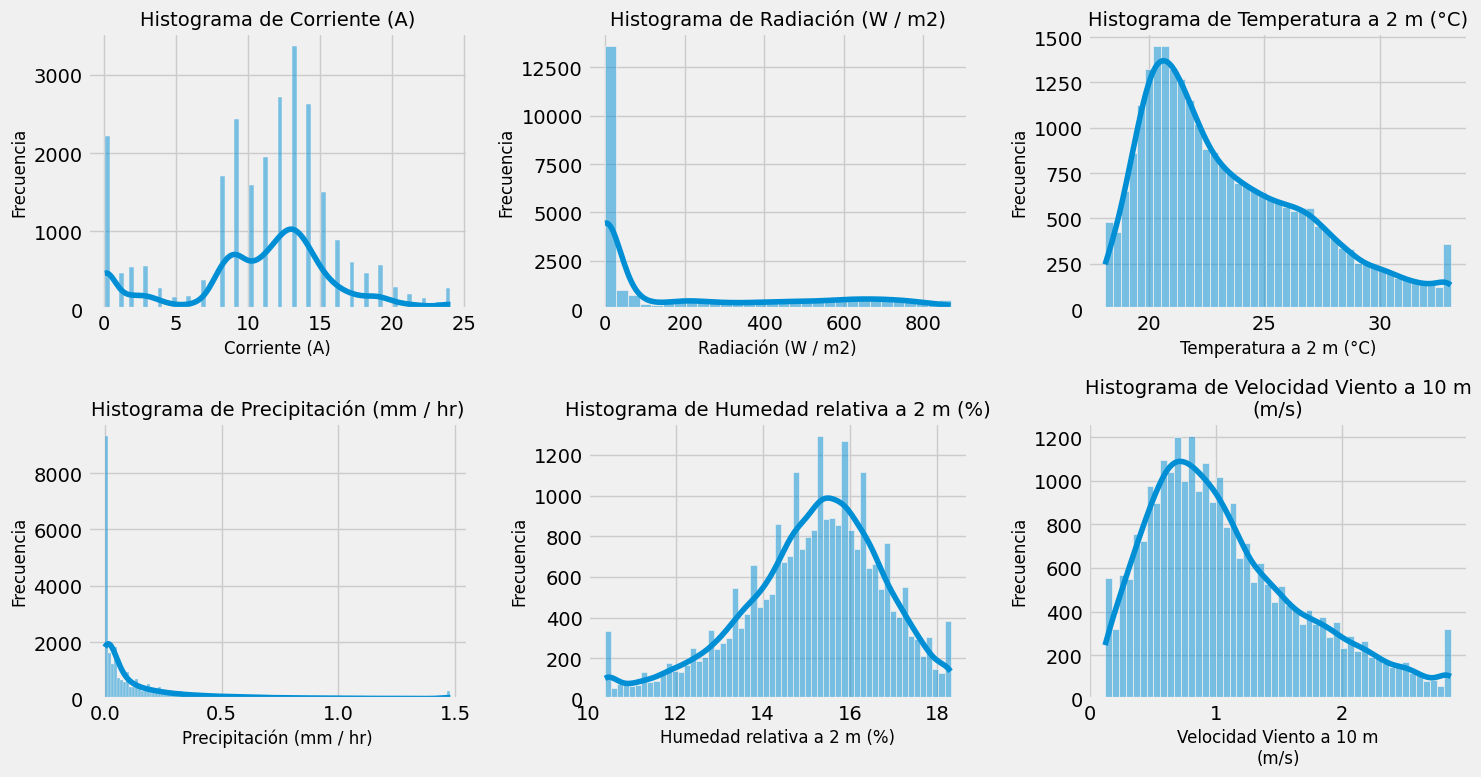

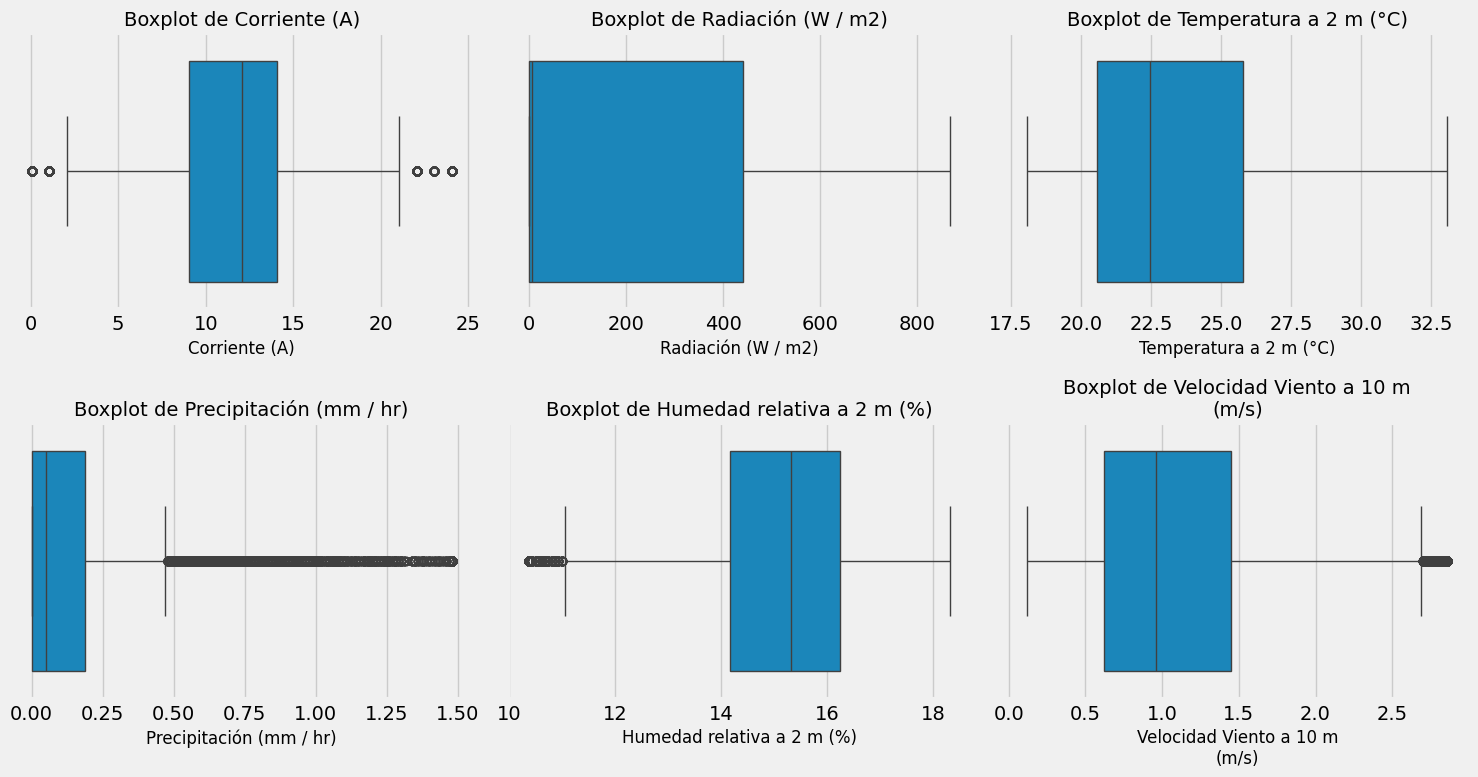

In [116]:
# Obtener las columnas del DataFrame excluyendo la primera columna
columns = df_original_df.iloc[:,:6].columns

# Definir el número de gráficos por fila
num_plots_per_row = 3

# Calcular el número de filas necesarias
num_rows = math.ceil(len(columns) / num_plots_per_row)

# Figura para histogramas
fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(15, num_rows * 4))
axes = axes.flatten()

for i, column in enumerate(columns):
    sns.histplot(data=df_original_df, x=column, ax=axes[i], kde=True)
    axes[i].set_title(f'Histograma de {column}', fontsize=14)
    axes[i].set_xlabel(column, fontsize=12) # Ajusta el tamaño de letra del eje X
    axes[i].set_ylabel('Frecuencia', fontsize=12) # Ajusta el tamaño de letra del eje Y)

# Remover cualquier subplot extra
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Figura para boxplots
fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(15, num_rows * 4))
axes = axes.flatten()

for i, column in enumerate(columns):
    sns.boxplot(data=df_original_df, x=column, ax=axes[i])
    axes[i].set_title(f'Boxplot de {column}', fontsize=14)
    axes[i].set_xlabel(column, fontsize=12) # Ajusta el tamaño de letra del eje X
    axes[i].set_ylabel('', fontsize=12)  # Ajusta el tamaño de letra del eje Y (o déjalo vacío))

# Remover cualquier subplot extra
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [117]:
# Asegúrate de que la columna 'Fecha' esté en formato datetime
df['Tiempo'] = pd.to_datetime(df['Tiempo'], format='%Y-%m-%d %H:%M:%S')
df_original_df['Tiempo']=df['Tiempo'].values
df_original_df.head()

Corriente (A)  Radiación (W / m2)  Temperatura a 2 m (°C)  \
0      18.050276                 0.0                   21.05   
1      16.050245                 0.0                   20.50   
2      14.050215                 0.0                   20.00   
3      13.050200                 0.0                   19.44   
4      12.050184                 0.0                   18.79   

   Precipitación (mm / hr)  Humedad relativa a 2 m (%)  \
0             3.100000e-01                       13.92   
1             6.938894e-18                       14.10   
2             6.938894e-18                       14.28   
3             6.938894e-18                       14.28   
4             6.938894e-18                       14.16   

   Velocidad Viento a 10 m\n(m/s)              Tiempo  
0                            0.49 2021-01-01 00:00:00  
1                            0.67 2021-01-01 01:00:00  
2                            0.78 2021-01-01 02:00:00  
3                            1.05 2021-01-01 03:00:00  
4                            1.19 2021-01-01 04:00:00

In [119]:
# Preparar datos y cambiar nombre de columna

df1 = df_original_df[['Tiempo','Corriente (A)']].copy()
df1['Año'] = df1['Tiempo'].dt.year
df_filtered = df1[df1['Año'].isin([2021, 2022, 2023])]

# Crear figura con subplots independientes
fig = sp.make_subplots(rows=3, cols=1,
                      subplot_titles=[f'Año {year}' for year in [2021, 2022, 2023]],
                      vertical_spacing=0.1)

# Configurar colores y añadir trazas
colors = qualitative.Dark24
for i, year in enumerate([2021, 2022, 2023], 1):
    df_year = df_filtered[df_filtered['Año'] == year]

    fig.add_trace(
        px.line(df_year,
                x='Tiempo',
                y='Corriente (A)',
                color_discrete_sequence=[colors[i-1]]
               ).data[0],
        row=i,
        col=1
    )

    # Personalizar layout individual para cada año
    fig.update_xaxes(
        title_text="Fecha" if i == 3 else None,
        tickformat="%b-%d-%Y",
        row=i,
        col=1
    )

    fig.update_yaxes(
        title_text='Corriente (A)' if i == 2 else None,
        range=[0, df_year['Corriente (A)'].max() * 1.1],
        row=i,
        col=1
    )

# Configuración general del layout
fig.update_layout(
    title_text='<b>Corriente (A)</b>',
    title_x=0.5,
    title_font=dict(size=24, color='black'),
    height=900,
    width=1200,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    margin=dict(l=60, r=30, b=60, t=100)
)

# Ajustar títulos de subplots
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=14, color='#333333')

fig.show()

#**Creación de variables sintéticas**

In [123]:
# Constantes del sistema
tension_linea_a_linea = 13200  # kV
tension_linea_a_neutro = tension_linea_a_linea / np.sqrt(3)  # kV
factor_potencia = 0.95  # Ajustar según sea necesario

# Función para calcular la potencia generada (ajusta la eficiencia según tu sistema)
def calcular_potencia_generada(radiacion, eficiencia=0.2):
    """Calcula la potencia generada a partir de la radiación y la eficiencia del panel.

    Args:
        radiacion (float): Valor de la radiación solar en W/m².
        eficiencia (float, optional): Eficiencia del panel solar. Defaults to 0.2.

    Returns:
        float: Potencia generada en kW.
    """
    # Ajusta el área del panel según tu sistema
    area_panel = 1.7  # m² (ejemplo)
    area_total = area_panel*1200
    potencia = radiacion * area_total * eficiencia / 1000  # Convertir a kW
    return potencia

# Función para calcular la potencia aparente por fase (basada en corriente)
def calcular_potencia_aparente_fase(corriente):
    """Calcula la potencia aparente por fase.

    Args:
        corriente (float): Valor de la corriente por fase en amperios (A).

    Returns:
        float: Potencia aparente por fase en kVA.
    """
    potencia_aparente = corriente * tension_linea_a_neutro / 1000
    return potencia_aparente

# Función para calcular la potencia activa por fase
def calcular_potencia_activa_fase(potencia_aparente):
    """Calcula la potencia activa por fase.

    Args:
        potencia_aparente (float): Potencia aparente por fase en kVA.

    Returns:
        float: Potencia activa por fase en kW.
    """
    potencia_activa = potencia_aparente * factor_potencia
    return potencia_activa



# Función para calcular el factor de solar (SF)
def calcular_sf(potencia_generada, potencia_demandada, umbral=1e-5):
    """Calcula el factor solar (SF), limitando el resultado al 100%.

    Args:
        potencia_generada (float): Potencia generada en kW.
        potencia_demandada (float): Potencia demandada en kW.
        umbral (float, optional): Umbral para evitar divisiones por valores cercanos a cero. Defaults to 1e-5.

    Returns:
        float: Factor solar, limitado al 100%.
    """
    if abs(potencia_demandada) < umbral:  # Evitar división por cero o valores cercanos
        return 0
    else:
        sf = potencia_generada / potencia_demandada
        return min(sf, 1.0)  # Limitar el SF al 100% (1.0 en decimal)

# Crear las nuevas columnas
df_original_df['Potencia Generada (kW)'] = df_original_df['Radiación (W / m2)'].apply(calcular_potencia_generada)
df_original_df['Potencia Aparente por Fase (kVA)'] = df_original_df['Corriente (A)'].apply(calcular_potencia_aparente_fase)
df_original_df['Potencia Activa por Fase (kW)'] = df_original_df['Potencia Aparente por Fase (kVA)'].apply(calcular_potencia_activa_fase)
df_original_df['Potencia Activa Total (kW)'] = df_original_df['Potencia Activa por Fase (kW)'] * 3
df_original_df['SF (%)'] = df_original_df.apply(lambda x: calcular_sf(x['Potencia Generada (kW)'], x['Potencia Activa Total (kW)']), axis=1)

df_original_df[['Tiempo', 'Potencia Generada (kW)', 'Potencia Activa Total (kW)', 'SF (%)']].head(5)

Tiempo  Potencia Generada (kW)  Potencia Activa Total (kW)  \
0 2021-01-01 00:00:00                     0.0                  392.050495   
1 2021-01-01 01:00:00                     0.0                  348.609997   
2 2021-01-01 02:00:00                     0.0                  305.169500   
3 2021-01-01 03:00:00                     0.0                  283.449252   
4 2021-01-01 04:00:00                     0.0                  261.729003   

   SF (%)  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

#**Correlación**

In [124]:
# Computing Correlation Matrices
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
from scipy.stats.stats import kendalltau

corr_p = df_original_df[['Corriente (A)', 'Radiación (W / m2)',
       'Temperatura a 2 m (°C)', 'Precipitación (mm / hr)',
       'Humedad relativa a 2 m (%)', 'Velocidad Viento a 10 m\n(m/s)','SF (%)','Potencia Generada (kW)','Potencia Activa Total (kW)']].corr(method='pearson')
print('Pearson correlation matrix')
corr_p
#print("\n")


Pearson correlation matrix


Corriente (A)  Radiación (W / m2)  \
Corriente (A)                        1.000000            0.090289   
Radiación (W / m2)                   0.090289            1.000000   
Temperatura a 2 m (°C)               0.140735            0.737362   
Precipitación (mm / hr)              0.029023           -0.181239   
Humedad relativa a 2 m (%)           0.105470           -0.366062   
Velocidad Viento a 10 m\n(m/s)       0.106025            0.511006   
SF (%)                              -0.081312            0.928145   
Potencia Generada (kW)               0.090289            1.000000   
Potencia Activa Total (kW)           1.000000            0.090289   

                                Temperatura a 2 m (°C)  \
Corriente (A)                                 0.140735   
Radiación (W / m2)                            0.737362   
Temperatura a 2 m (°C)                        1.000000   
Precipitación (mm / hr)                      -0.220556   
Humedad relativa a 2 m (%)                   -0.400355   
Velocidad Viento a 10 m\n(m/s)                0.404818   
SF (%)                                        0.702450   
Potencia Generada (kW)                        0.737362   
Potencia Activa Total (kW)                    0.140735   

                                Precipitación (mm / hr)  \
Corriente (A)                                  0.029023   
Radiación (W / m2)                            -0.181239   
Temperatura a 2 m (°C)                        -0.220556   
Precipitación (mm / hr)                        1.000000   
Humedad relativa a 2 m (%)                     0.323752   
Velocidad Viento a 10 m\n(m/s)                -0.154223   
SF (%)                                        -0.183104   
Potencia Generada (kW)                        -0.181239   
Potencia Activa Total (kW)                     0.029023   

                                Humedad relativa a 2 m (%)  \
Corriente (A)                                     0.105470   
Radiación (W / m2)                               -0.366062   
Temperatura a 2 m (°C)                           -0.400355   
Precipitación (mm / hr)                           0.323752   
Humedad relativa a 2 m (%)                        1.000000   
Velocidad Viento a 10 m\n(m/s)                   -0.286184   
SF (%)                                           -0.358394   
Potencia Generada (kW)                           -0.366062   
Potencia Activa Total (kW)                        0.105470   

                                Velocidad Viento a 10 m\n(m/s)    SF (%)  \
Corriente (A)                                         0.106025 -0.081312   
Radiación (W / m2)                                    0.511006  0.928145   
Temperatura a 2 m (°C)                                0.404818  0.702450   
Precipitación (mm / hr)                              -0.154223 -0.183104   
Humedad relativa a 2 m (%)                           -0.286184 -0.358394   
Velocidad Viento a 10 m\n(m/s)                        1.000000  0.485873   
SF (%)                                                0.485873  1.000000   
Potencia Generada (kW)                                0.511006  0.928145   
Potencia Activa Total (kW)                            0.106025 -0.081312   

                                Potencia Generada (kW)  \
Corriente (A)                                 0.090289   
Radiación (W / m2)                            1.000000   
Temperatura a 2 m (°C)                        0.737362   
Precipitación (mm / hr)                      -0.181239   
Humedad relativa a 2 m (%)                   -0.366062   
Velocidad Viento a 10 m\n(m/s)                0.511006   
SF (%)                                        0.928145   
Potencia Generada (kW)                        1.000000   
Potencia Activa Total (kW)                    0.090289   

                                Potencia Activa Total (kW)  
Corriente (A)                                     1.000000  
Radiación (W / m2)                                0.090289  
Temperatura a 2 m (°C) 

In [125]:
corr_s = df_original_df[['Corriente (A)', 'Radiación (W / m2)',
       'Temperatura a 2 m (°C)', 'Precipitación (mm / hr)',
       'Humedad relativa a 2 m (%)', 'Velocidad Viento a 10 m\n(m/s)','SF (%)','Potencia Generada (kW)','Potencia Activa Total (kW)']].corr(method='spearman')
print('Spearman correlation matrix')
corr_s

Spearman correlation matrix


Corriente (A)  Radiación (W / m2)  \
Corriente (A)                        1.000000            0.211656   
Radiación (W / m2)                   0.211656            1.000000   
Temperatura a 2 m (°C)               0.287434            0.720891   
Precipitación (mm / hr)              0.035537           -0.166492   
Humedad relativa a 2 m (%)           0.101211           -0.323047   
Velocidad Viento a 10 m\n(m/s)       0.156132            0.504556   
SF (%)                               0.090697            0.969036   
Potencia Generada (kW)               0.211656            1.000000   
Potencia Activa Total (kW)           1.000000            0.211656   

                                Temperatura a 2 m (°C)  \
Corriente (A)                                 0.287434   
Radiación (W / m2)                            0.720891   
Temperatura a 2 m (°C)                        1.000000   
Precipitación (mm / hr)                      -0.240240   
Humedad relativa a 2 m (%)                   -0.185389   
Velocidad Viento a 10 m\n(m/s)                0.372139   
SF (%)                                        0.692819   
Potencia Generada (kW)                        0.720891   
Potencia Activa Total (kW)                    0.287434   

                                Precipitación (mm / hr)  \
Corriente (A)                                  0.035537   
Radiación (W / m2)                            -0.166492   
Temperatura a 2 m (°C)                        -0.240240   
Precipitación (mm / hr)                        1.000000   
Humedad relativa a 2 m (%)                     0.459766   
Velocidad Viento a 10 m\n(m/s)                -0.143567   
SF (%)                                        -0.170107   
Potencia Generada (kW)                        -0.166492   
Potencia Activa Total (kW)                     0.035537   

                                Humedad relativa a 2 m (%)  \
Corriente (A)                                     0.101211   
Radiación (W / m2)                               -0.323047   
Temperatura a 2 m (°C)                           -0.185389   
Precipitación (mm / hr)                           0.459766   
Humedad relativa a 2 m (%)                        1.000000   
Velocidad Viento a 10 m\n(m/s)                   -0.268077   
SF (%)                                           -0.316857   
Potencia Generada (kW)                           -0.323047   
Potencia Activa Total (kW)                        0.101211   

                                Velocidad Viento a 10 m\n(m/s)    SF (%)  \
Corriente (A)                                         0.156132  0.090697   
Radiación (W / m2)                                    0.504556  0.969036   
Temperatura a 2 m (°C)                                0.372139  0.692819   
Precipitación (mm / hr)                              -0.143567 -0.170107   
Humedad relativa a 2 m (%)                           -0.268077 -0.316857   
Velocidad Viento a 10 m\n(m/s)                        1.000000  0.481780   
SF (%)                                                0.481780  1.000000   
Potencia Generada (kW)                                0.504556  0.969036   
Potencia Activa Total (kW)                            0.156132  0.090697   

                                Potencia Generada (kW)  \
Corriente (A)                                 0.211656   
Radiación (W / m2)                            1.000000   
Temperatura a 2 m (°C)                        0.720891   
Precipitación (mm / hr)                      -0.166492   
Humedad relativa a 2 m (%)                   -0.323047   
Velocidad Viento a 10 m\n(m/s)                0.504556   
SF (%)                                        0.969036   
Potencia Generada (kW)                        1.000000   
Potencia Activa Total (kW)                    0.211656   

                                Potencia Activa Total (kW)  
Corriente (A)                                     1.000000  
Radiación (W / m2)                                0.211656  
Temperatura a 2 m (°C) 

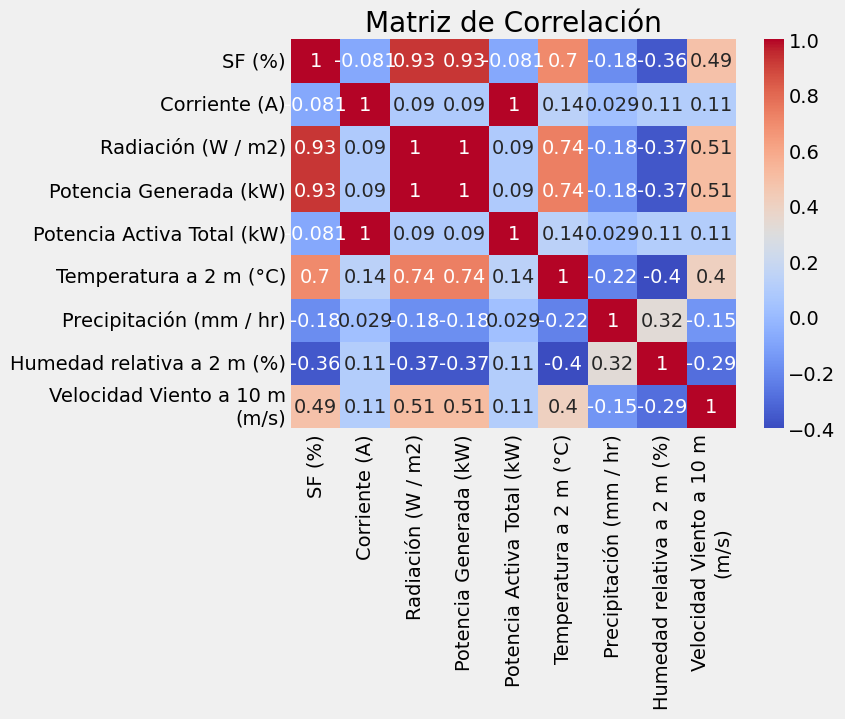

In [128]:
import seaborn as sns

# 1. Exploración de la colinealidad
corr_matrix = df_original_df[['SF (%)','Corriente (A)', 'Radiación (W / m2)','Potencia Generada (kW)','Potencia Activa Total (kW)',
       'Temperatura a 2 m (°C)', 'Precipitación (mm / hr)',
       'Humedad relativa a 2 m (%)', 'Velocidad Viento a 10 m\n(m/s)']].corr(method='pearson')

# Visualizar la matriz de correlación como un mapa de calor
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

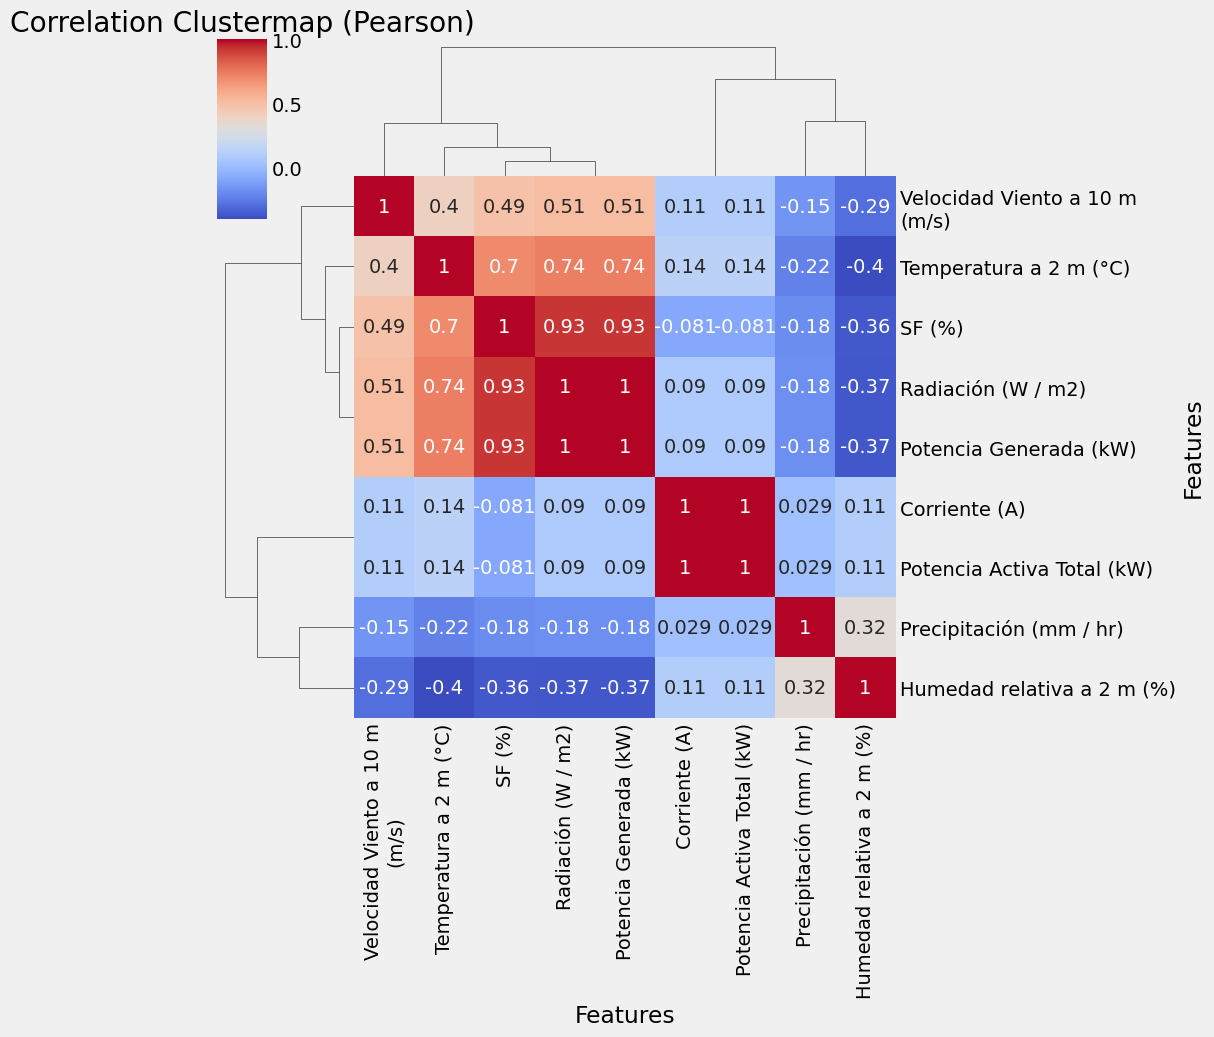

In [129]:
# Create a clustermap with annotations
g = sns.clustermap(corr_matrix, annot=True, cmap='coolwarm')

# Add title and labels
plt.title("Correlation Clustermap (Pearson)")
g.ax_heatmap.set_xlabel("Features")
g.ax_heatmap.set_ylabel("Features")

plt.show()

#**Análisis gráfico**

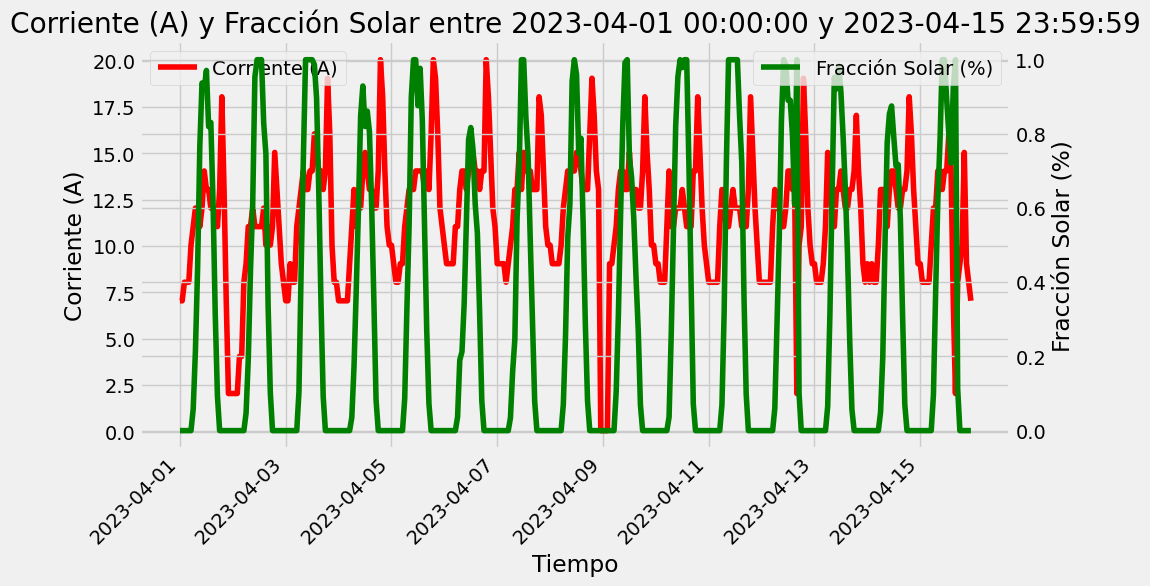

In [131]:
def graficar_intervalo(df, inicio, fin):
    # Filtrar el DataFrame con el rango de tiempo definido
    df_filtrado = df[(df['Tiempo'] >= inicio) & (df['Tiempo'] <= fin)]

    # Crear la gráfica
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Gráfica de Potencia Generada y Potencia Demandada en el eje y izquierdo
    #ax1.plot(df_filtrado['Tiempo'], df_filtrado['Potencia Generada (kW)'], label='Potencia Generada (kW)', color='b')
    ax1.plot(df_filtrado['Tiempo'], df_filtrado['Corriente (A)'], label='Corriente (A)', color='r')
    ax1.set_xlabel('Tiempo')
    ax1.set_ylabel('Corriente (A)')
    ax1.legend(loc='upper left')

    # Crear un segundo eje y para la fracción solar
    ax2 = ax1.twinx()
    ax2.plot(df_filtrado['Tiempo'], df_filtrado['SF (%)'], label='Fracción Solar (%)', color='g')
    ax2.set_ylabel('Fracción Solar (%)')
    ax2.legend(loc='upper right')

    # Título y mostrar la gráfica
    plt.title(f'Corriente (A) y Fracción Solar entre {inicio} y {fin}')
    fig.autofmt_xdate(rotation=45, ha='right')
    plt.show()

# Ejemplo de uso:
# Definir el lapso de tiempo que deseas ver
inicio = '2023-04-01 00:00:00'
fin = '2023-04-15 23:59:59'

# Llamar la función para graficar
graficar_intervalo(df_original_df, inicio, fin)


In [132]:
# Filtrar filas basadas en un rango de tiempo específico
# Definir los límites del rango de tiempo (ejemplo: de 2023-01-01 a 2023-01-31)
inicio = '2022-08-29 00:00:00'
fin = '2022-08-29 23:59:59'

# Filtrar el DataFrame entre las fechas seleccionadas
df_filtrado = df[(df['Tiempo'] >= inicio) & (df['Tiempo'] <= fin)]

# Mostrar las primeras filas del DataFrame filtrado
df_filtrado.head(24)  # Puedes cambiar el número de filas a visualizar

Tiempo  Corriente (A)  Radiación (W / m2)  \
14520 2022-08-29 00:00:00       9.050138                0.00   
14521 2022-08-29 01:00:00       9.050138                0.00   
14522 2022-08-29 02:00:00       9.050138                0.00   
14523 2022-08-29 03:00:00       9.050138                0.00   
14524 2022-08-29 04:00:00       9.050138                0.00   
14525 2022-08-29 05:00:00      11.050169                0.00   
14526 2022-08-29 06:00:00      15.050230               37.70   
14527 2022-08-29 07:00:00      13.050200              172.12   
14528 2022-08-29 08:00:00      11.050169              359.07   
14529 2022-08-29 09:00:00      12.050184              489.24   
14530 2022-08-29 10:00:00      11.050169              561.60   
14531 2022-08-29 11:00:00      46.050701              558.91   
14532 2022-08-29 12:00:00      46.050701              503.58   
14533 2022-08-29 13:00:00      45.050686              558.81   
14534 2022-08-29 14:00:00      43.050655              463.55   
14535 2022-08-29 15:00:00      43.050655              304.39   
14536 2022-08-29 16:00:00      43.050655              164.41   
14537 2022-08-29 17:00:00      46.050701               41.80   
14538 2022-08-29 18:00:00      53.050808                0.00   
14539 2022-08-29 19:00:00      67.051025                0.00   
14540 2022-08-29 20:00:00      59.050900                0.00   
14541 2022-08-29 21:00:00      46.050701                0.00   
14542 2022-08-29 22:00:00      36.050549                0.00   
14543 2022-08-29 23:00:00      31.050474                0.00   

       Temperatura a 2 m (°C)  Precipitación (mm / hr)  \
14520                   18.98                     0.61   
14521                   18.55                     0.44   
14522                   18.15                     0.29   
14523                   17.90                     0.15   
14524                   17.80                     0.09   
14525                   17.89                     0.07   
14526                   18.99                     0.07   
14527                   21.13                     0.02   
14528                   23.40                     0.03   
14529                   24.87                     0.05   
14530                   26.01                     0.07   
14531                   26.82                     0.09   
14532                   27.20                     0.11   
14533                   27.21                     0.14   
14534                   26.71                     0.16   
14535                   25.89                     0.16   
14536                   24.89                     0.15   
14537                   23.69                     0.12   
14538                   22.70                     0.10   
14539                   22.28                     0.12   
14540                   21.76                     0.12   
14541                   21.26                     0.12   
14542                   20.75                     0.13   
14543                   20.13                     0.13   

       Humedad relativa a 2 m (%)  Velocidad Viento a 10 m\n(m/s)  
14520                       13.92                            1.31  
14521                       13.67                            1.39  
14522                       13.55                            1.39  
14523                       13.31                            1.32  
14524                       13.00                            1.26  
14525                       12.57                            1.12  
14526                       13.12                            0.87  
14527                       14.10                            1.03  
14528                       14.34                            1.02  
14529                       13.55                            1.26  
14530                       13.79                            1.44  
14531                       14.04                            1.55  
14532                       14.28                            1.67  
14533          

In [133]:
df_plt = df_original_df.copy('Deep')

In [134]:
# Copiar la columna 'Fecha' de df a df_plt
#df_plt['Tiempo'] = df['Tiempo'].values

df_plt = df_plt.set_index('Tiempo')

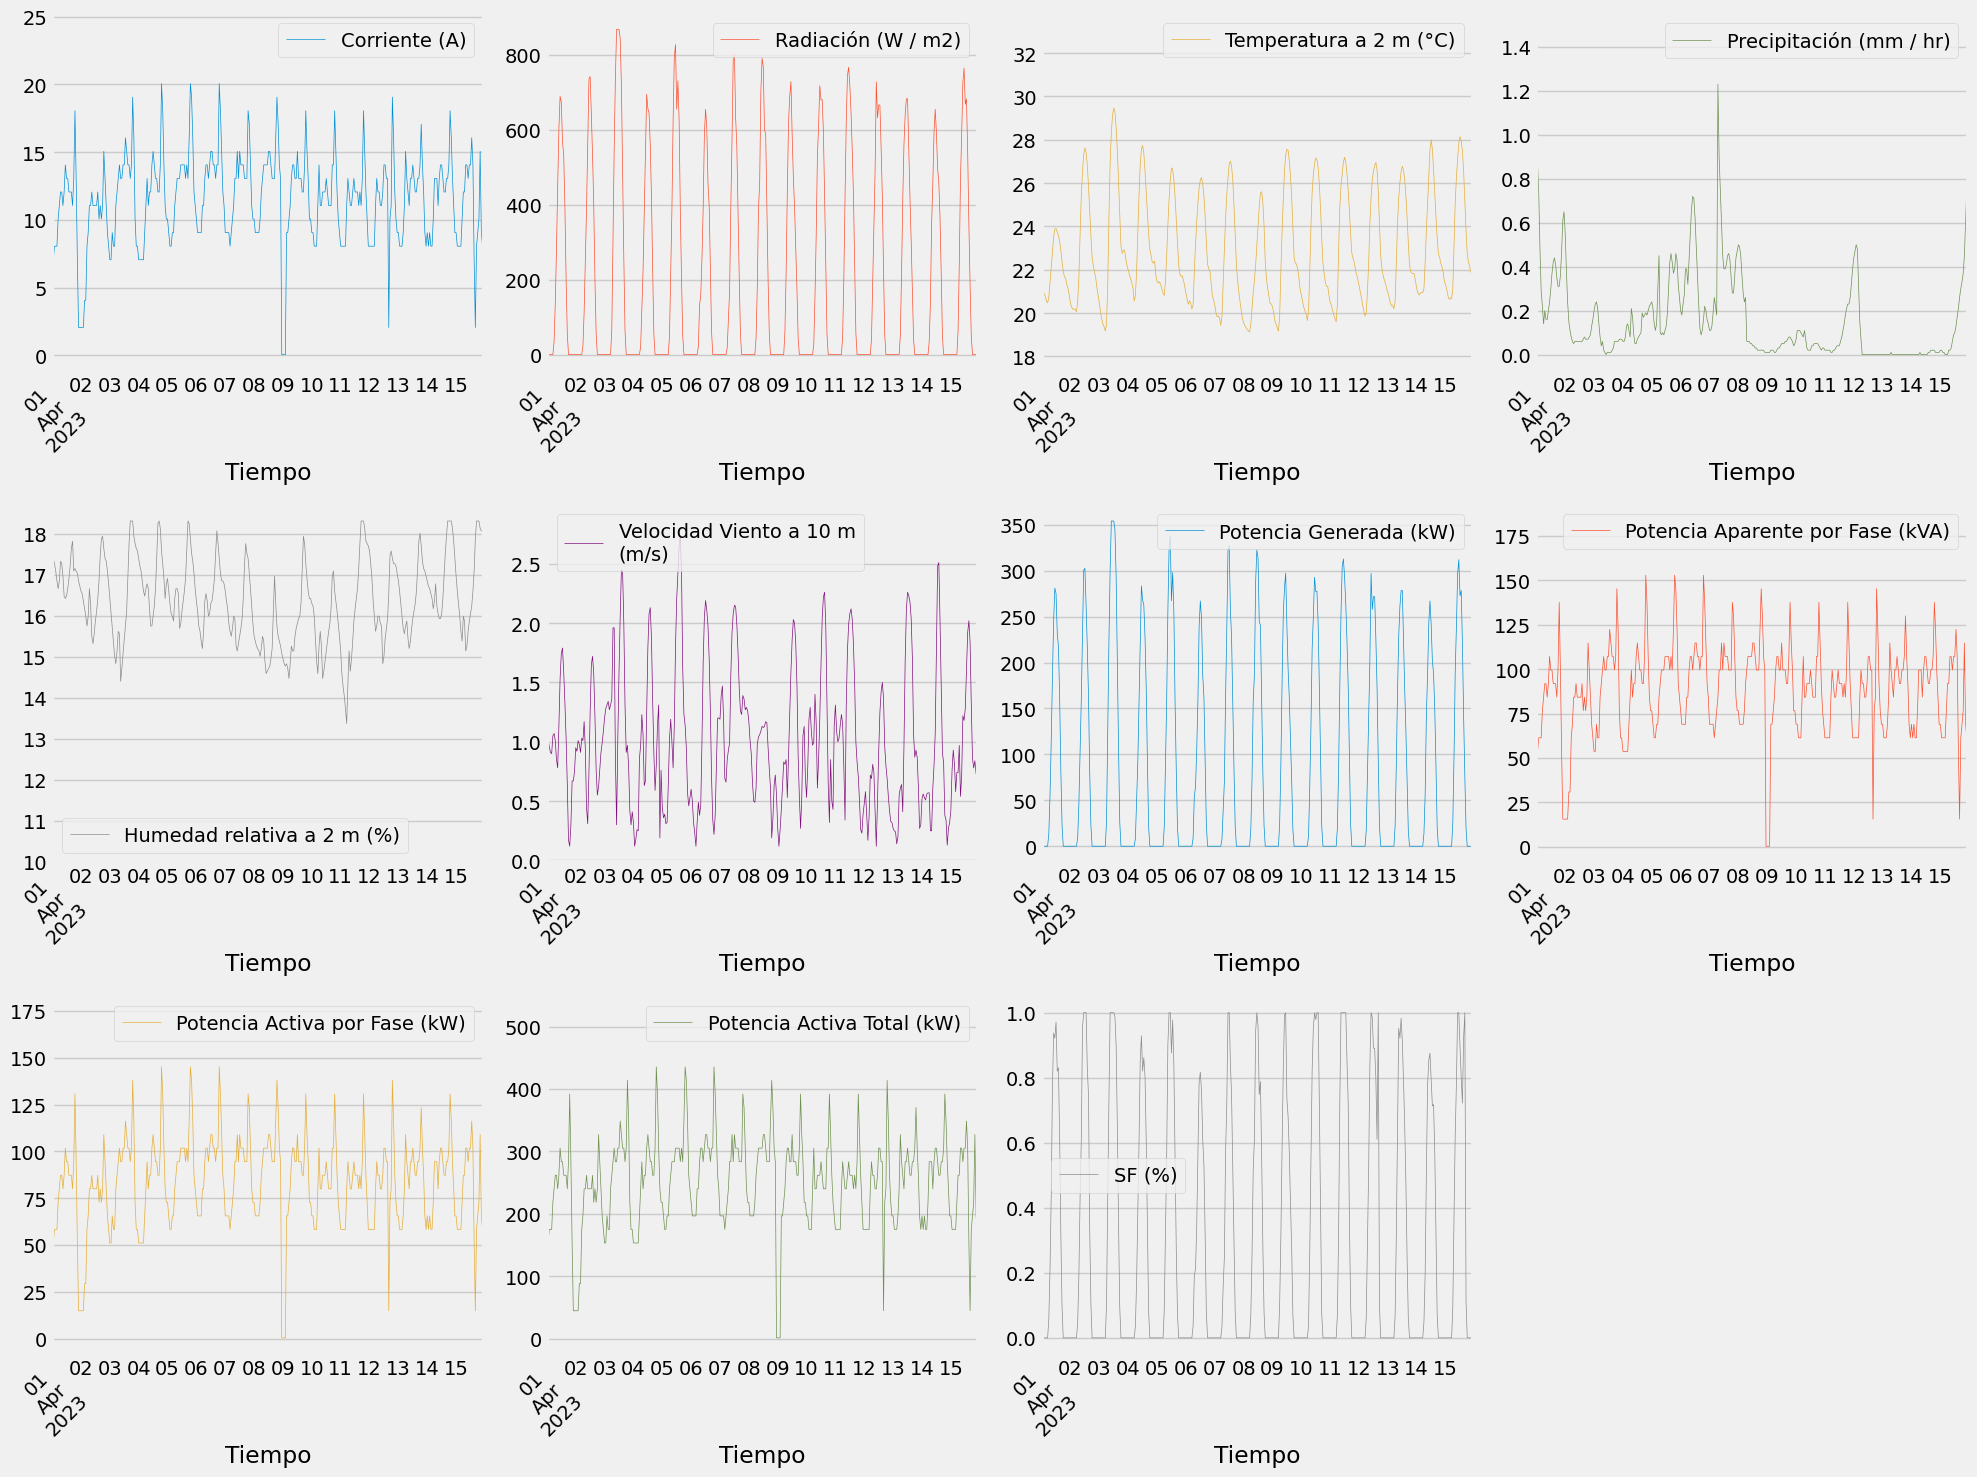

In [135]:
# Facet plots
axes = df_plt.plot(subplots=True,
                   linewidth=0.5,
                   layout=(3, 4),
                   figsize=(20, 15),
                   sharex=False,
                   sharey=False,
                   xlim=['2023-04-01 00:00:00', '2023-04-15 23:59:59'])

# Rotate x-axis labels
for ax in axes.flatten():
    ax.tick_params(axis='x', rotation=45)  # Rotate by 45 degrees

plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

In [136]:
df_N = df_original_df.copy()

# Copiar la columna 'Fecha' de df a df_N
df_N['Tiempo'] = df['Tiempo'].values

df_N = df_N.set_index('Tiempo')

df_N.head()

Corriente (A)  Radiación (W / m2)  \
Tiempo                                                   
2021-01-01 00:00:00      18.050276                 0.0   
2021-01-01 01:00:00      16.050245                 0.0   
2021-01-01 02:00:00      14.050215                 0.0   
2021-01-01 03:00:00      13.050200                 0.0   
2021-01-01 04:00:00      12.050184                 0.0   

                     Temperatura a 2 m (°C)  Precipitación (mm / hr)  \
Tiempo                                                                 
2021-01-01 00:00:00                   21.05             3.100000e-01   
2021-01-01 01:00:00                   20.50             6.938894e-18   
2021-01-01 02:00:00                   20.00             6.938894e-18   
2021-01-01 03:00:00                   19.44             6.938894e-18   
2021-01-01 04:00:00                   18.79             6.938894e-18   

                     Humedad relativa a 2 m (%)  \
Tiempo                                            
2021-01-01 00:00:00                       13.92   
2021-01-01 01:00:00                       14.10   
2021-01-01 02:00:00                       14.28   
2021-01-01 03:00:00                       14.28   
2021-01-01 04:00:00                       14.16   

                     Velocidad Viento a 10 m\n(m/s)  Potencia Generada (kW)  \
Tiempo                                                                        
2021-01-01 00:00:00                            0.49                     0.0   
2021-01-01 01:00:00                            0.67                     0.0   
2021-01-01 02:00:00                            0.78                     0.0   
2021-01-01 03:00:00                            1.05                     0.0   
2021-01-01 04:00:00                            1.19                     0.0   

                     Potencia Aparente por Fase (kVA)  \
Tiempo                                                  
2021-01-01 00:00:00                        137.561577   
2021-01-01 01:00:00                        122.319297   
2021-01-01 02:00:00                        107.077018   
2021-01-01 03:00:00                         99.455878   
2021-01-01 04:00:00                         91.834738   

                     Potencia Activa por Fase (kW)  \
Tiempo                                               
2021-01-01 00:00:00                     130.683498   
2021-01-01 01:00:00                     116.203332   
2021-01-01 02:00:00                     101.723167   
2021-01-01 03:00:00                      94.483084   
2021-01-01 04:00:00                      87.243001   

                     Potencia Activa Total (kW)  SF (%)  
Tiempo                                                   
2021-01-01 00:00:00                  392.050495     0.0  
2021-01-01 01:00:00                  348.609997     0.0  
2021-01-01 02:00:00                  305.169500     0.0  
2021-01-01 03:00:00                  283.449252     0.0  
2021-01-01 04:00:00                  261.729003     0.0

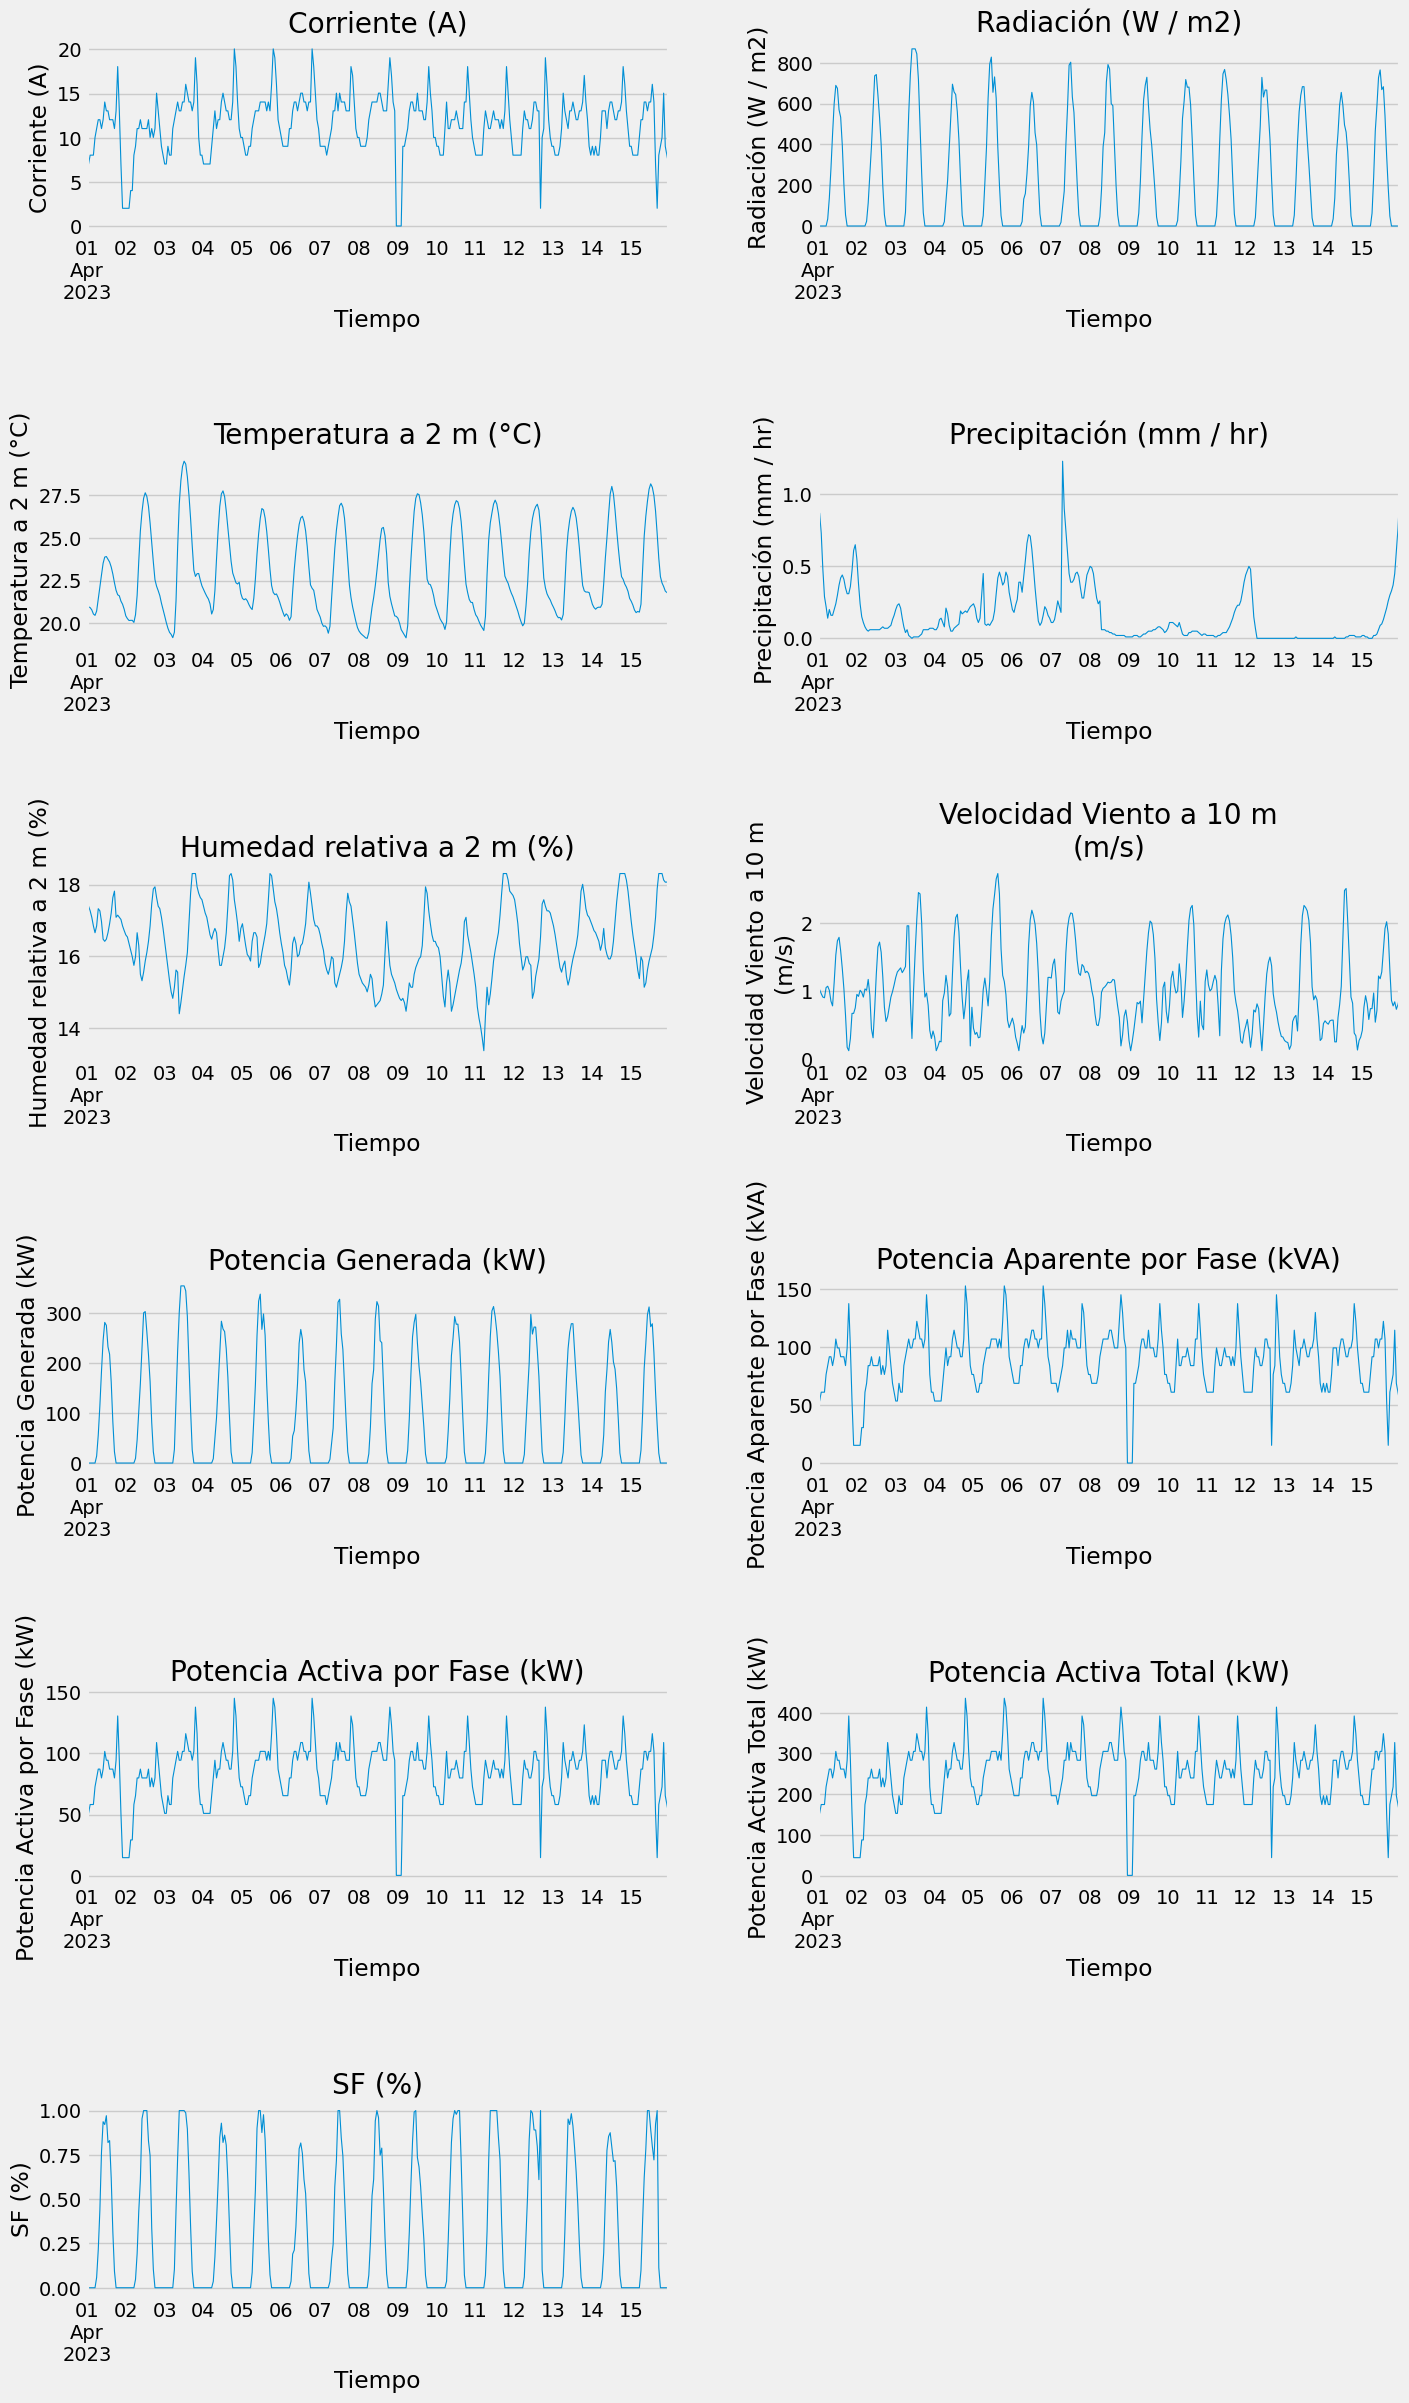

In [137]:
import matplotlib.pyplot as plt

# Filtro temporal según rango definido por el usuario
inicio = '2023-04-01'  # Fecha inicial (modificar según necesidad)
fin = '2023-04-15'     # Fecha final (modificar según necesidad)
df_filtrado = df_N.loc[inicio:fin]  # Filtrar DataFrame por rango de fechas

# Verificar si el rango tiene datos
if df_filtrado.empty:
    print(f"No hay datos disponibles entre {inicio} y {fin}. Por favor, selecciona otro rango.")
else:
    plt.style.use('fivethirtyeight')

    # Facet plots con diseño optimizado
    fig, axes = plt.subplots(
        nrows=6,  # Ajusta las filas según la cantidad de columnas
        ncols=2,  # Máximo dos columnas para mejor visualización
        figsize=(15, 25)  # Tamaño más amplio y alto
    )

    # Asegúrate de ajustar el número total de subplots según tus variables
    columns = df_filtrado.columns.tolist()
    for ax, col in zip(axes.flatten(), columns):
        df_filtrado[col].plot(ax=ax, linewidth=0.8, title=col)
        ax.set_xlabel("Tiempo")  # Etiqueta X
        ax.set_ylabel(col)       # Etiqueta Y basada en la columna

    # Elimina subplots vacíos si hay menos gráficos que ejes generados
    for ax in axes.flatten()[len(columns):]:
        ax.remove()

    plt.tight_layout(pad=3.0)  # Ajusta el espaciado entre subplots
    plt.show()

In [138]:
df_con = df_original_df.copy('deep')

# Copiar la columna 'Fecha' de df a df_N
df_con['Tiempo'] = df['Tiempo'].values

df_con["Fecha"] = pd.to_datetime(df["Tiempo"]).dt.date
df_con["Hora"] = pd.to_datetime(df["Tiempo"]).dt.time
df_con = df_con.set_index('Tiempo')
df_con = df_con[["Potencia Activa Total (kW)", "Potencia Generada (kW)",'SF (%)', "Fecha" , "Hora"]]["2023-04-01 00:00:00" : "2023-04-30 23:59:59"]
df_con.head()

Potencia Activa Total (kW)  Potencia Generada (kW)  \
Tiempo                                                                    
2023-04-01 00:00:00                  153.127750                     0.0   
2023-04-01 01:00:00                  153.127750                     0.0   
2023-04-01 02:00:00                  174.848009                     0.0   
2023-04-01 03:00:00                  174.848009                     0.0   
2023-04-01 04:00:00                  174.848009                     0.0   

                     SF (%)       Fecha      Hora  
Tiempo                                             
2023-04-01 00:00:00     0.0  2023-04-01  00:00:00  
2023-04-01 01:00:00     0.0  2023-04-01  01:00:00  
2023-04-01 02:00:00     0.0  2023-04-01  02:00:00  
2023-04-01 03:00:00     0.0  2023-04-01  03:00:00  
2023-04-01 04:00:00     0.0  2023-04-01  04:00:00

In [139]:
df_con_pro = df_con.pivot_table(values=["Potencia Activa Total (kW)", "Potencia Generada (kW)",'SF (%)'], index='Fecha', columns='Hora')


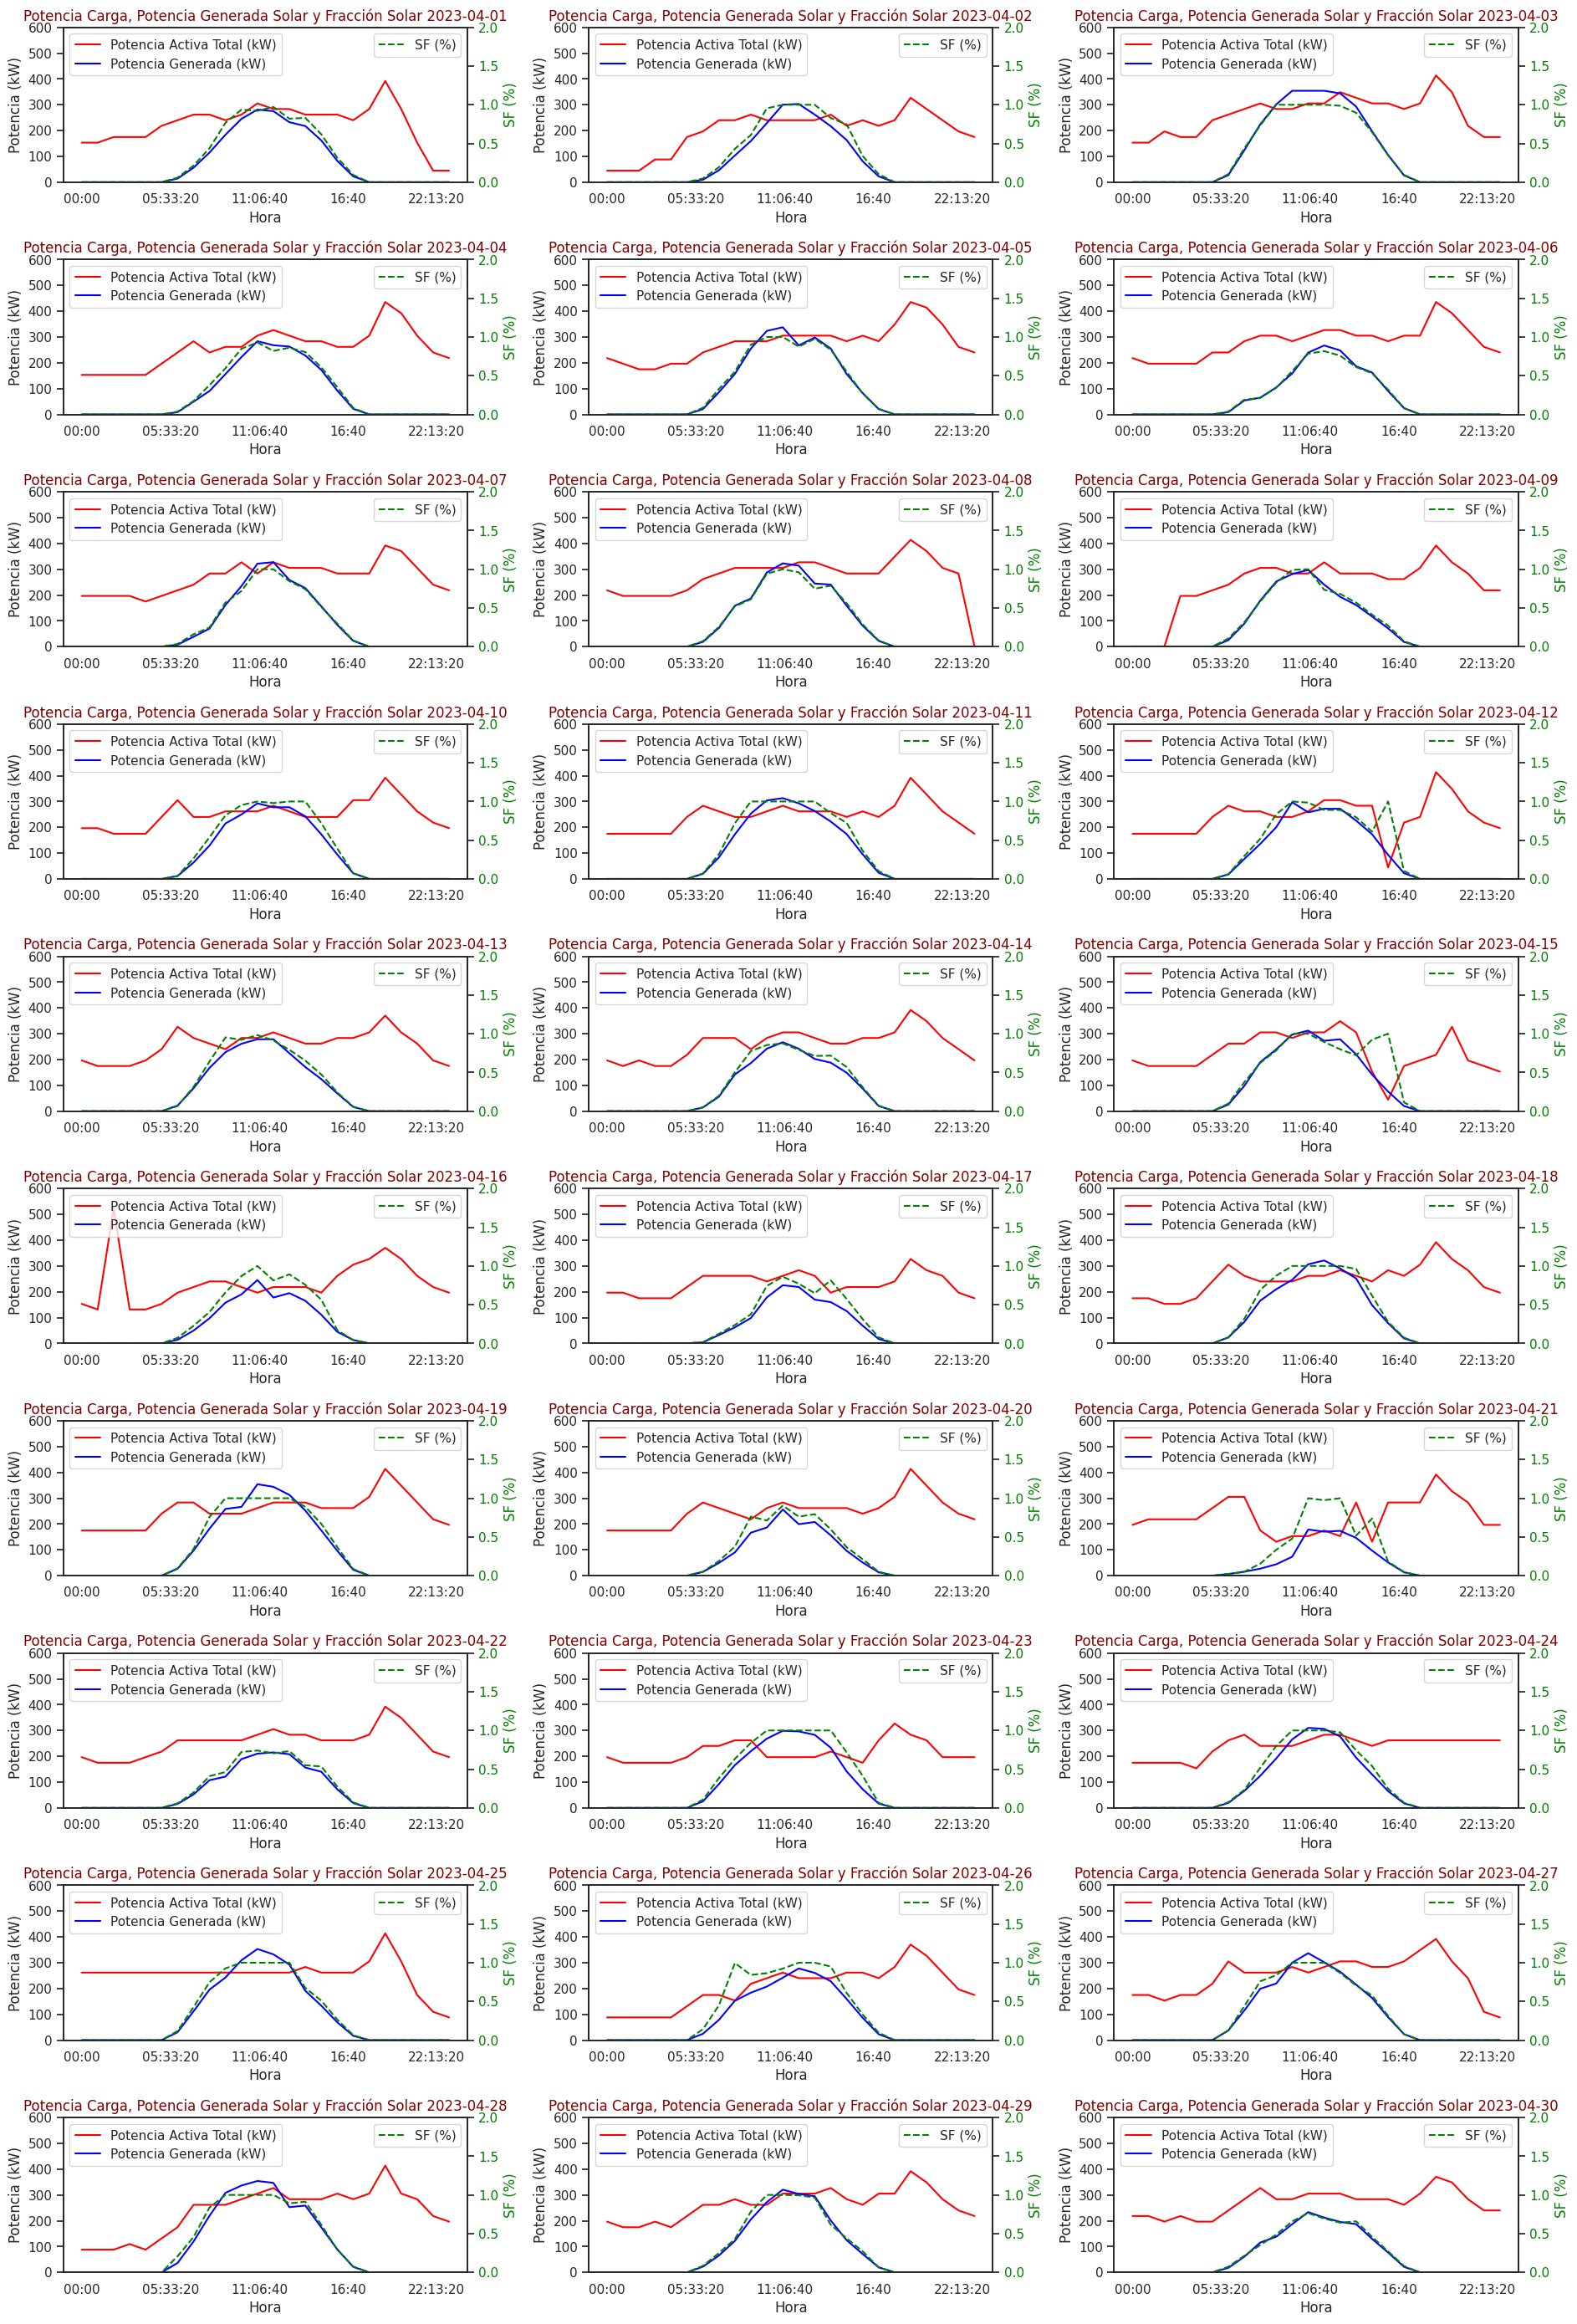

<Figure size 640x480 with 0 Axes>

In [140]:
sns.set_theme(style="white")
df_con_pro = df_con.pivot_table(values=["Potencia Activa Total (kW)", "Potencia Generada (kW)", 'SF (%)'], index='Hora', columns='Fecha')

def Daywise_plot(data=None, row=None, col=None, title='Potencia Carga, Potencia Generada Solar y Fracción Solar', ylim_top=600):
    """
    Plots timeseries data for each column in a grid layout with a secondary y-axis for SF (%).

    Args:
        data: A pandas DataFrame containing the timeseries data.
        row: Number of rows in the grid layout (optional).
        col: Number of columns in the grid layout (optional).
        title: Title for the overall plot (optional).
        ylim_top: Upper limit for the y-axis (optional, default: 8000).
    """
    cols = data.columns.levels[1]  # Get all column names (dates)

    # Create the figure with desired size
    gp = plt.figure(figsize=(20, 40))

    # Adjust spacing between subplots
    gp.subplots_adjust(wspace=0.3, hspace=0.5)

    for i in range(1, len(cols) + 1):
        ax = gp.add_subplot(row, col, i)

        # Plot Potencia Activa Total y Potencia Generada on the primary y-axis
        data['Potencia Activa Total (kW)', cols[i - 1]].plot(ax=ax, color='red', label='Potencia Activa Total (kW)')
        data['Potencia Generada (kW)', cols[i - 1]].plot(ax=ax, color='blue', label='Potencia Generada (kW)')

        # Set title, labels, and limits for the primary y-axis
        ax.set_title('{} {}'.format(title, cols[i - 1]), color='#800000')
        ax.set_ylim(0, ylim_top)
        ax.set_ylabel('Potencia (kW)')
        ax.legend(loc='upper left')

        # Create secondary y-axis for SF (%)
        ax2 = ax.twinx()
        data['SF (%)', cols[i - 1]].plot(ax=ax2, color='green', linestyle='--', label='SF (%)')
        ax2.set_ylim(0, 2)  # Adjust this range based on the SF (%) values
        ax2.set_ylabel('SF (%)', color='green')
        ax2.tick_params(axis='y', labelcolor='green')

        # Add legend for the secondary y-axis
        ax2.legend(loc='upper right')

    # Display the plot
    plt.show()

# Call the function with desired parameters and new y-axis limit
Daywise_plot(data=df_con_pro, row=12, col=3, ylim_top=600)
plt.tight_layout()
plt.show()

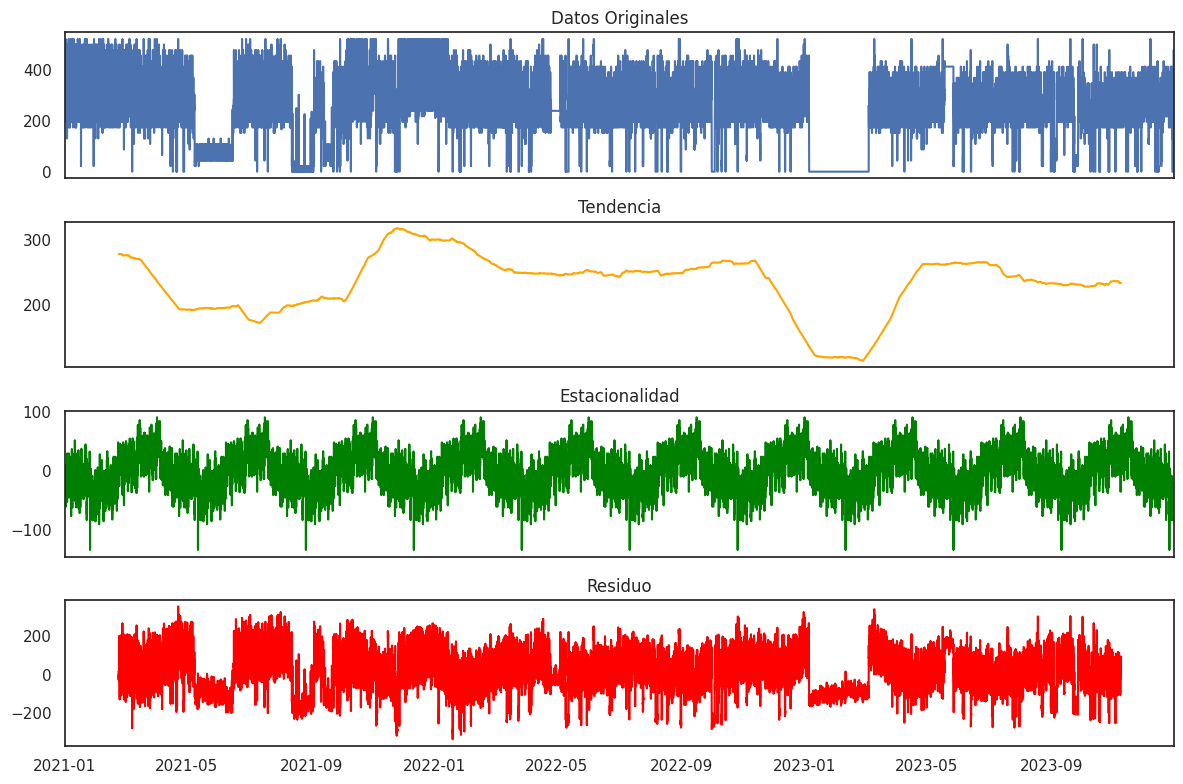

In [141]:
#Descomposición aditiva: Descomposición de la serie en la suma de tres series que representen: la tendencia, la estacionalidad y la aleatoriedad.

from statsmodels.tsa.seasonal import seasonal_decompose

col='Potencia Activa Total (kW)'
T=365*7
# Descomposición para todos los datos
components = seasonal_decompose(df_N[col], model='additive', period=T)

# Extraer los componentes
tendencia = components.trend
estacionalidad = components.seasonal
residuo = components.resid

# Convertir límites del eje X a datetime
start_date = pd.to_datetime('2021-01-01')
end_date = pd.to_datetime('2023-12-31')

# Graficar los componentes con ajuste del eje x
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

# Datos originales
axes[0].plot(df_N.index, df_N[col], label='Datos Originales')
axes[0].set_title('Datos Originales')
axes[0].set_xlim(start_date, end_date)

# Tendencia
axes[1].plot(tendencia.index, tendencia, label='Tendencia', color='orange')
axes[1].set_title('Tendencia')
axes[1].set_xlim(start_date, end_date)

# Estacionalidad
axes[2].plot(estacionalidad.index, estacionalidad, label='Estacionalidad', color='green')
axes[2].set_title('Estacionalidad')
axes[2].set_xlim(start_date,end_date)

# Residuo
axes[3].plot(residuo.index, residuo, label='Residuo', color='red')
axes[3].set_title('Residuo')
axes[3].set_xlim(start_date,end_date)

plt.tight_layout()
plt.show()

#**Dickey-Fuller test**

In [142]:
def test_stationarity(timeseries):
# Calculate rolling mean and standard deviation
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
# Plot original timeseries, rolling mean, and rolling standard deviation
    plt.figure(figsize=(20,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='purple',label='Original')
    mean = plt.plot(rolmean, color='yellow', label='Rolling Mean')
    std = plt.plot(rolstd, color='cyan', label = 'Rolling Std')
# Add legend
    plt.legend(loc='best')
# Add title
    plt.title('Media y desviación estandar móvil de Potencia Activa Total (kW)')
    plt.show()
# Perform and display results of Dickey-Fuller test
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                    index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [143]:
dx = df_N['Potencia Activa Total (kW)']
dx.head()

Tiempo
2021-01-01 00:00:00    392.050495
2021-01-01 01:00:00    348.609997
2021-01-01 02:00:00    305.169500
2021-01-01 03:00:00    283.449252
2021-01-01 04:00:00    261.729003
Name: Potencia Activa Total (kW), dtype: float64

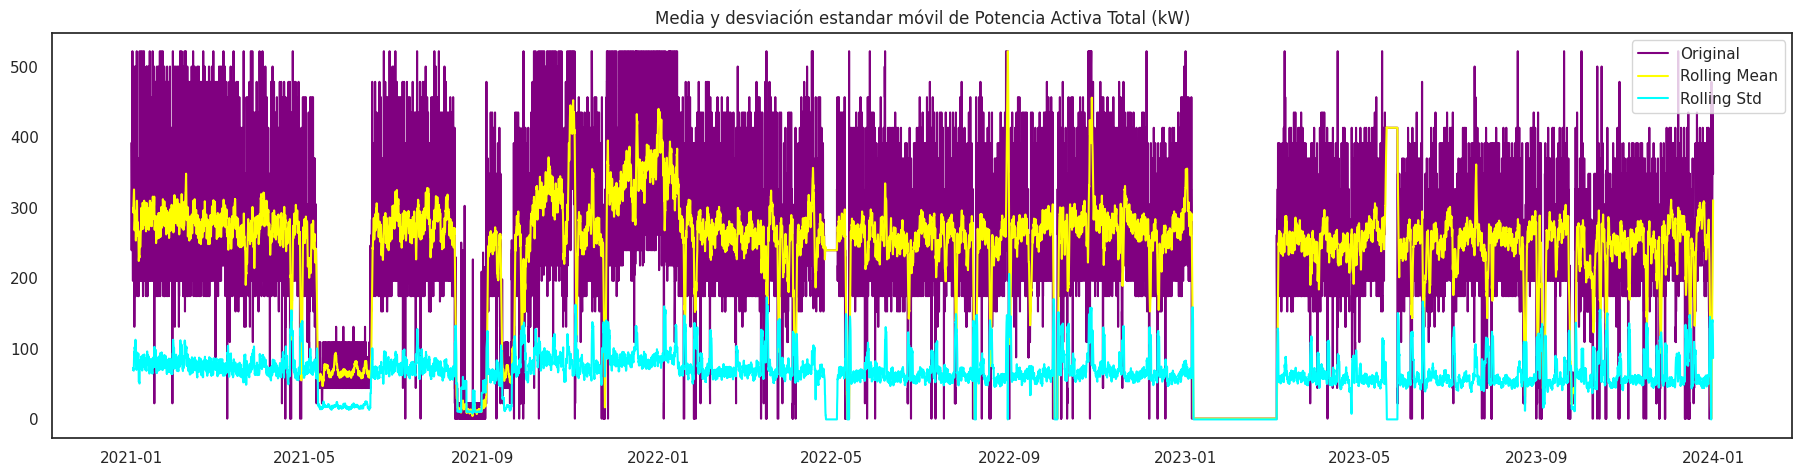

<Results of Dickey-Fuller Test>
Test Statistic                -8.066280e+00
p-value                        1.593118e-12
#Lags Used                     4.900000e+01
Number of Observations Used    2.623000e+04
Critical Value (1%)           -3.430599e+00
Critical Value (5%)           -2.861650e+00
Critical Value (10%)          -2.566829e+00
dtype: float64


In [144]:
test_stationarity(dx)

#**Modelo pronóstico**

##Forecasting with XGBoosts

In [145]:
df_xgb = df_N[['SF (%)']]
df_xgb.head(100)

SF (%)
Tiempo                     
2021-01-01 00:00:00     0.0
2021-01-01 01:00:00     0.0
2021-01-01 02:00:00     0.0
2021-01-01 03:00:00     0.0
2021-01-01 04:00:00     0.0
...                     ...
2021-01-04 23:00:00     0.0
2021-01-05 00:00:00     0.0
2021-01-05 01:00:00     0.0
2021-01-05 02:00:00     0.0
2021-01-05 03:00:00     0.0

[100 rows x 1 columns]

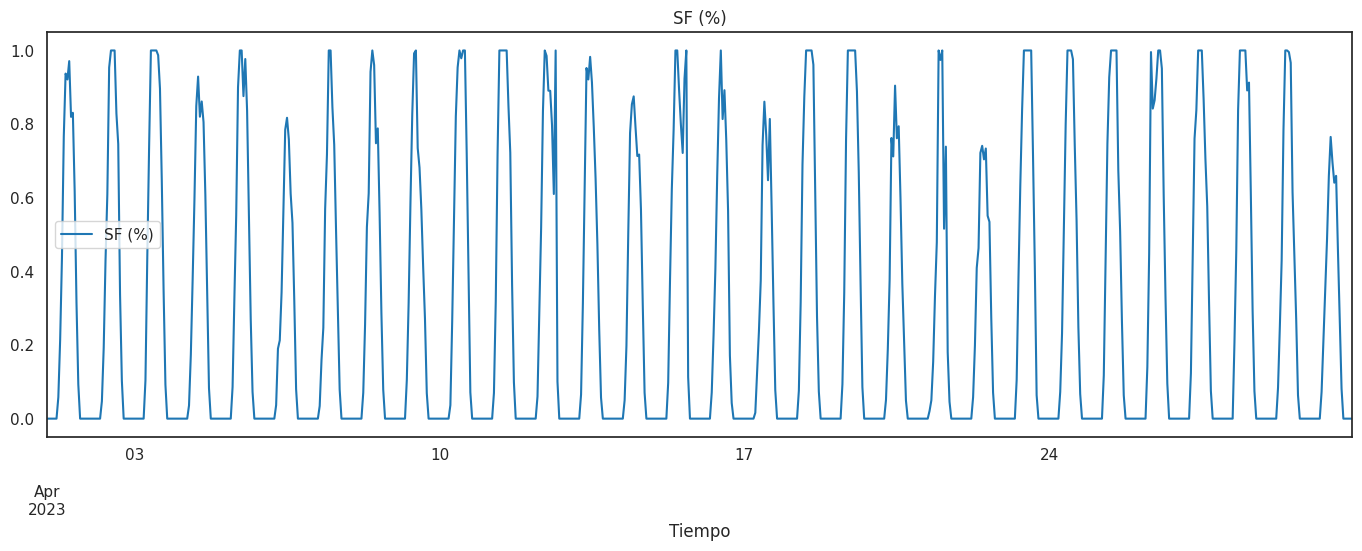

In [146]:
# Select data for the specified date range after plotting
df_xgb_filtered = df_xgb.loc['2023-04-01':'2023-04-30']

df_xgb_filtered.plot(
        figsize=(15, 5),
        color=color_pal[0],
        title='SF (%)')
plt.show()

<Axes: ylabel='Frequency'>

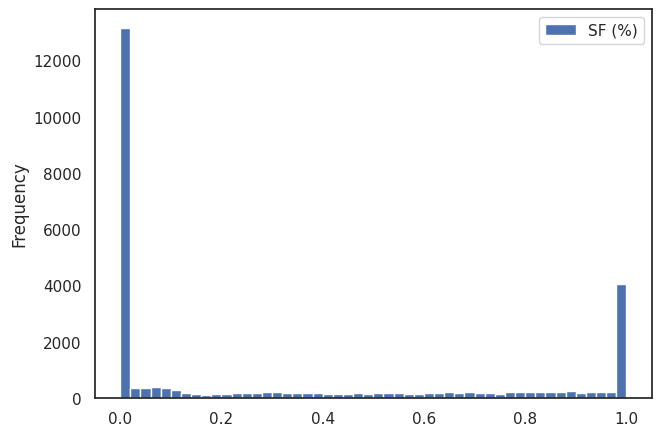

In [147]:
df_xgb.plot(kind='hist', bins=50)

##Time Series Cross Validation

In [148]:
# n_splits_max = (tamaño total datos- test size)/ (test size + GAP)
ttd = (3*364*24 )
ts = 24*364
gap = 24
n_splits_max = round((ttd-ts)/(ts+gap))
n_splits_max


2

In [149]:
from sklearn.model_selection import TimeSeriesSplit


tss = TimeSeriesSplit(n_splits=n_splits_max, test_size=ts, gap=gap)
df_xgb = df_xgb.sort_index()
df_xgb.head()

SF (%)
Tiempo                     
2021-01-01 00:00:00     0.0
2021-01-01 01:00:00     0.0
2021-01-01 02:00:00     0.0
2021-01-01 03:00:00     0.0
2021-01-01 04:00:00     0.0

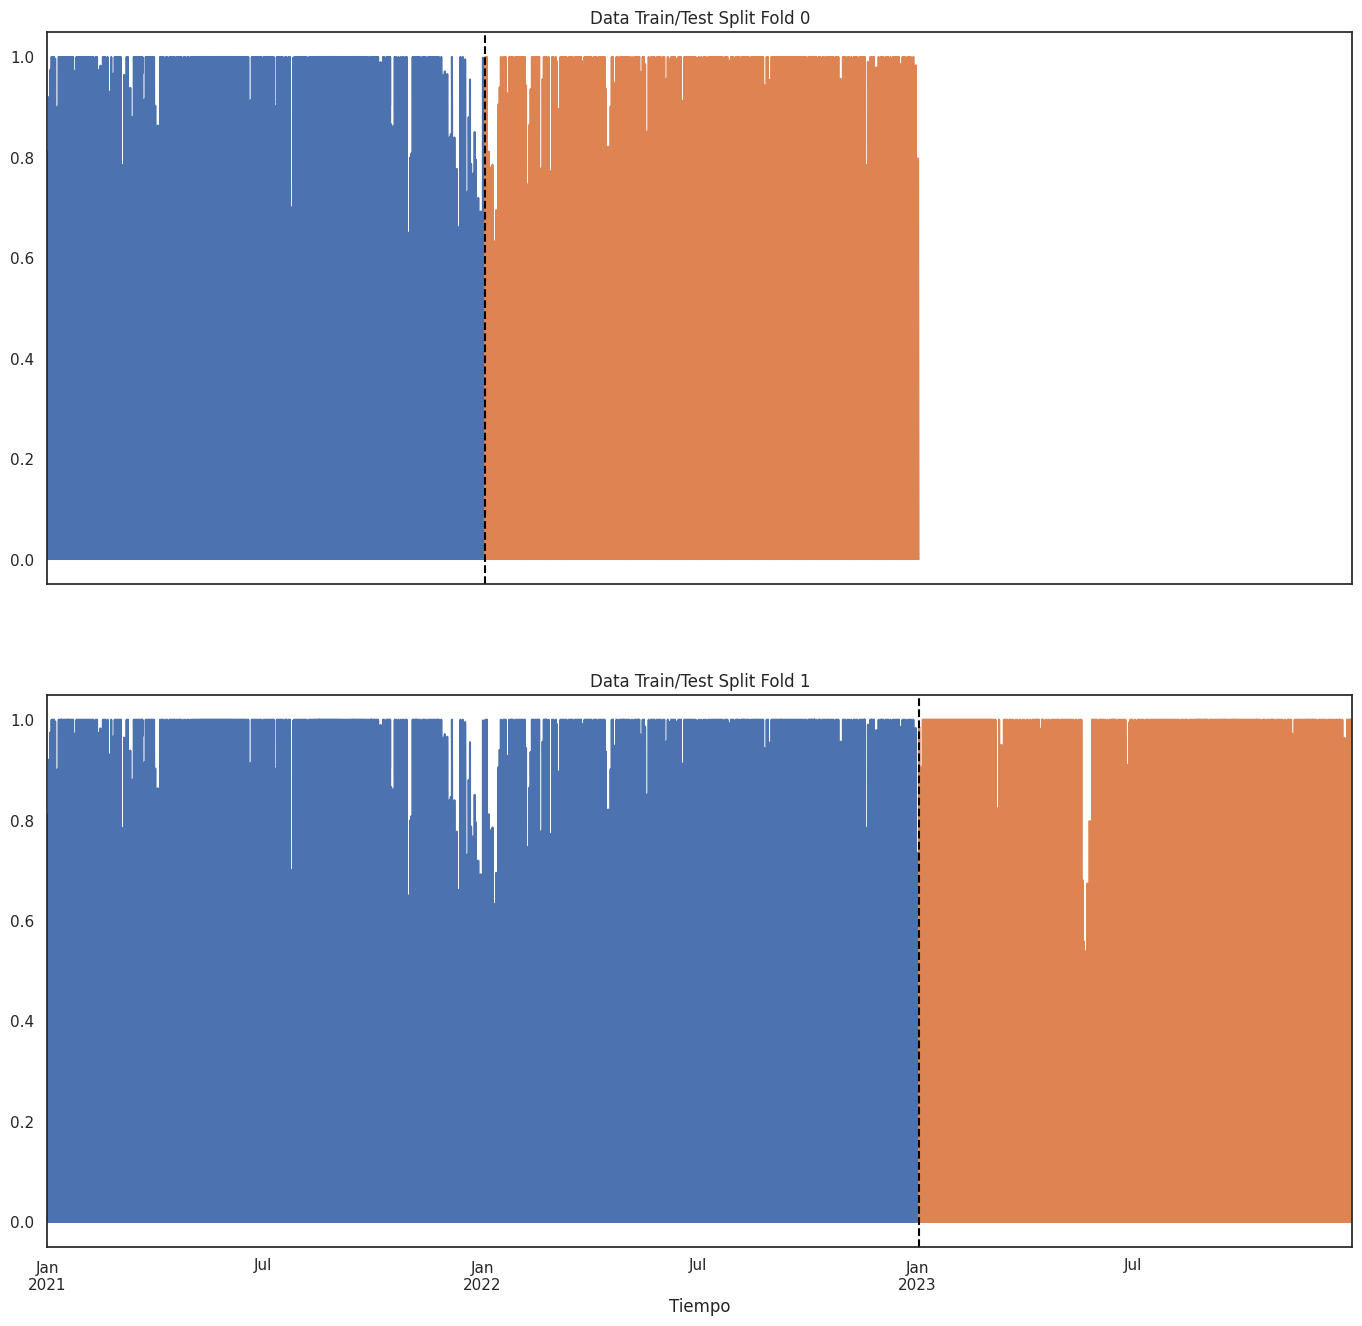

In [150]:
fig, axs = plt.subplots(2, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df_xgb):
    train = df_xgb.iloc[train_idx]
    test = df_xgb.iloc[val_idx]
    train['SF (%)'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['SF (%)'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

##Forecasting Horizon Explained

In [151]:
def create_features(dff):
    """
    Create time series features based on time series index.
    """
    # Use the 'df' parameter instead of the global 'df_xgb'
    dff = dff.copy()
    dff['hour'] = dff.index.hour
    dff['dayofweek'] = dff.index.dayofweek
    dff['quarter'] = dff.index.quarter
    dff['month'] = dff.index.month
    dff['year'] = dff.index.year
    dff['dayofyear'] = dff.index.dayofyear
    dff['dayofmonth'] = dff.index.day
    dff['weekofyear'] = dff.index.isocalendar().week
    return dff

df_xgb = create_features(df_xgb)

In [152]:
df_xgb.head(60)

SF (%)  hour  dayofweek  quarter  month  year  \
Tiempo                                                                 
2021-01-01 00:00:00  0.000000     0          4        1      1  2021   
2021-01-01 01:00:00  0.000000     1          4        1      1  2021   
2021-01-01 02:00:00  0.000000     2          4        1      1  2021   
2021-01-01 03:00:00  0.000000     3          4        1      1  2021   
2021-01-01 04:00:00  0.000000     4          4        1      1  2021   
2021-01-01 05:00:00  0.000000     5          4        1      1  2021   
2021-01-01 06:00:00  0.058971     6          4        1      1  2021   
2021-01-01 07:00:00  0.202378     7          4        1      1  2021   
2021-01-01 08:00:00  0.362717     8          4        1      1  2021   
2021-01-01 09:00:00  0.554792     9          4        1      1  2021   
2021-01-01 10:00:00  0.697493    10          4        1      1  2021   
2021-01-01 11:00:00  0.725162    11          4        1      1  2021   
2021-01-01 12:00:00  0.811844    12          4        1      1  2021   
2021-01-01 13:00:00  0.728058    13          4        1      1  2021   
2021-01-01 14:00:00  0.621829    14          4        1      1  2021   
2021-01-01 15:00:00  0.534424    15          4        1      1  2021   
2021-01-01 16:00:00  0.307662    16          4        1      1  2021   
2021-01-01 17:00:00  0.063425    17          4        1      1  2021   
2021-01-01 18:00:00  0.000000    18          4        1      1  2021   
2021-01-01 19:00:00  0.000000    19          4        1      1  2021   
2021-01-01 20:00:00  0.000000    20          4        1      1  2021   
2021-01-01 21:00:00  0.000000    21          4        1      1  2021   
2021-01-01 22:00:00  0.000000    22          4        1      1  2021   
2021-01-01 23:00:00  0.000000    23          4        1      1  2021   
2021-01-02 00:00:00  0.000000     0          5        1      1  2021   
2021-01-02 01:00:00  0.000000     1          5        1      1  2021   
2021-01-02 02:00:00  0.000000     2          5        1      1  2021   
2021-01-02 03:00:00  0.000000     3          5        1      1  2021   
2021-01-02 04:00:00  0.000000     4          5        1      1  2021   
2021-01-02 05:00:00  0.000000     5          5        1      1  2021   
2021-01-02 06:00:00  0.051255     6          5        1      1  2021   
2021-01-02 07:00:00  0.268321     7          5        1      1  2021   
2021-01-02 08:00:00  0.512069     8          5        1      1  2021   
2021-01-02 09:00:00  0.499183     9          5        1      1  2021   
2021-01-02 10:00:00  0.851535    10          5        1      1  2021   
2021-01-02 11:00:00  0.920494    11          5        1      1  2021   
2021-01-02 12:00:00  0.826241    12          5        1      1  2021   
2021-01-02 13:00:00  0.724560    13          5        1      1  2021   
2021-01-02 14:00:00  0.646218    14          5        1      1  2021   
2021-01-02 15:00:00  0.458737    15          5        1      1  2021   
2021-01-02 16:00:00  0.244918    16          5        1      1  2021   
2021-01-02 17:00:00  0.051553    17          5        1      1  2021   
2021-01-02 18:00:00  0.000000    18          5        1      1  2021   
2021-01-02 19:00:00  0.000000    19          5        1      1  2021   
2021-01-02 20:00:00  0.000000    20          5        1      1  2021   
2021-01-02 21:00:00  0.000000    21          5        1      1  2021   
2021-01-02 22:00:00  0.000000    22          5        1      1  2021   
2021-01-02 23:00:00  0.000000    23          5        1      1  2021   
2021-01-03 00:00:00  0.000000     0          6        1      1  2021   
2021-01-03 01:00:00  0.000000     1          6        1      1  2021   
2021-01-03 02:00:00  0.000000     2          6        1      1  2021   
2021-01-03 03:00:00  0.000000     3          6        1      1  2021   
2021-01-03 04:00:00  0.000000     4          6        1      1  2021   
2021-01-03 05:00:00  0.000000     5          6        1      1 

##Lag Features

In [153]:
def add_lags(dfl):
    target_map = df_xgb['SF (%)'].to_dict()
    dfl['lag1'] = (dfl.index - pd.Timedelta('364 days')).map(target_map)
    dfl['lag2'] = (dfl.index - pd.Timedelta('1092 days')).map(target_map)
    #dfl['lag3'] = (dfl.index - pd.Timedelta('1092 days')).map(target_map)
    return dfl

In [154]:
df_xgb = add_lags(df_xgb)
df_xgb.tail(60)

SF (%)  hour  dayofweek  quarter  month  year  \
Tiempo                                                                 
2023-12-29 12:00:00  1.000000    12          4        4     12  2023   
2023-12-29 13:00:00  1.000000    13          4        4     12  2023   
2023-12-29 14:00:00  1.000000    14          4        4     12  2023   
2023-12-29 15:00:00  1.000000    15          4        4     12  2023   
2023-12-29 16:00:00  1.000000    16          4        4     12  2023   
2023-12-29 17:00:00  1.000000    17          4        4     12  2023   
2023-12-29 18:00:00  0.000000    18          4        4     12  2023   
2023-12-29 19:00:00  0.000000    19          4        4     12  2023   
2023-12-29 20:00:00  0.000000    20          4        4     12  2023   
2023-12-29 21:00:00  0.000000    21          4        4     12  2023   
2023-12-29 22:00:00  0.000000    22          4        4     12  2023   
2023-12-29 23:00:00  0.000000    23          4        4     12  2023   
2023-12-30 00:00:00  0.000000     0          5        4     12  2023   
2023-12-30 01:00:00  0.000000     1          5        4     12  2023   
2023-12-30 02:00:00  0.000000     2          5        4     12  2023   
2023-12-30 03:00:00  0.000000     3          5        4     12  2023   
2023-12-30 04:00:00  0.000000     4          5        4     12  2023   
2023-12-30 05:00:00  0.000000     5          5        4     12  2023   
2023-12-30 06:00:00  1.000000     6          5        4     12  2023   
2023-12-30 07:00:00  1.000000     7          5        4     12  2023   
2023-12-30 08:00:00  1.000000     8          5        4     12  2023   
2023-12-30 09:00:00  1.000000     9          5        4     12  2023   
2023-12-30 10:00:00  1.000000    10          5        4     12  2023   
2023-12-30 11:00:00  1.000000    11          5        4     12  2023   
2023-12-30 12:00:00  1.000000    12          5        4     12  2023   
2023-12-30 13:00:00  1.000000    13          5        4     12  2023   
2023-12-30 14:00:00  1.000000    14          5        4     12  2023   
2023-12-30 15:00:00  1.000000    15          5        4     12  2023   
2023-12-30 16:00:00  1.000000    16          5        4     12  2023   
2023-12-30 17:00:00  0.098845    17          5        4     12  2023   
2023-12-30 18:00:00  0.000000    18          5        4     12  2023   
2023-12-30 19:00:00  0.000000    19          5        4     12  2023   
2023-12-30 20:00:00  0.000000    20          5        4     12  2023   
2023-12-30 21:00:00  0.000000    21          5        4     12  2023   
2023-12-30 22:00:00  0.000000    22          5        4     12  2023   
2023-12-30 23:00:00  0.000000    23          5        4     12  2023   
2023-12-31 00:00:00  0.000000     0          6        4     12  2023   
2023-12-31 01:00:00  0.000000     1          6        4     12  2023   
2023-12-31 02:00:00  0.000000     2          6        4     12  2023   
2023-12-31 03:00:00  0.000000     3          6        4     12  2023   
2023-12-31 04:00:00  0.000000     4          6        4     12  2023   
2023-12-31 05:00:00  0.000000     5          6        4     12  2023   
2023-12-31 06:00:00  0.068521     6          6        4     12  2023   
2023-12-31 07:00:00  0.268000     7          6        4     12  2023   
2023-12-31 08:00:00  0.502173     8          6        4     12  2023   
2023-12-31 09:00:00  0.648761     9          6        4     12  2023   
2023-12-31 10:00:00  0.960714    10          6        4     12  2023   
2023-12-31 11:00:00  0.883961    11          6        4     12  2023   
2023-12-31 12:00:00  0.837581    12          6        4     12  2023   
2023-12-31 13:00:00  0.715974    13          6        4     12  2023   
2023-12-31 14:00:00  0.563956    14          6        4     12  2023   
2023-12-31 15:00:00  0.445264    15          6        4     12  2023   
2023-12-31 16:00:00  0.220625    16          6        4     12  2023   
2023-12-31 17:00:00  0.043245    17          6        4     12 

##Train Using Cross Validation

In [155]:
tss = TimeSeriesSplit(n_splits=2, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df_xgb):
    train = df_xgb.iloc[train_idx]
    test = df_xgb.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2']
    TARGET = 'SF (%)'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:0.43729	validation_1-rmse:0.42956
[100]	validation_0-rmse:0.21813	validation_1-rmse:0.20654
[200]	validation_0-rmse:0.15830	validation_1-rmse:0.14765
[300]	validation_0-rmse:0.14033	validation_1-rmse:0.13518
[400]	validation_0-rmse:0.13023	validation_1-rmse:0.13379
[424]	validation_0-rmse:0.12853	validation_1-rmse:0.13384
[0]	validation_0-rmse:0.43440	validation_1-rmse:0.44593
[100]	validation_0-rmse:0.22142	validation_1-rmse:0.23506
[200]	validation_0-rmse:0.15566	validation_1-rmse:0.18810
[300]	validation_0-rmse:0.13928	validation_1-rmse:0.18514
[320]	validation_0-rmse:0.13737	validation_1-rmse:0.18543


In [156]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.1591
Fold scores:[0.13369212028820607, 0.18448935009277312]


##Predicting the Future

In [ ]:
!pip install scikit-learn==1.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.0/32.0 MB 20.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.1.3 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.1.3 which is incompatible.
bigframes 1.34.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.3 which is incompatible.


In [157]:
!pip install --upgrade xgboost

In [158]:
import sklearn
sklearn.set_config(display='text')

In [ ]:
#from sklearn.model_selection import RandomizedSearchCV
#from scipy.stats import randint

#param_dist = {
 #       'n_estimators': randint(100, 500),
   #     'max_depth': randint(3, 10),
   #     'learning_rate': [0.01, 0.1, 0.2]
   # }

#random_search = RandomizedSearchCV(estimator=reg, param_distributions=param_dist, n_iter=10, scoring='neg_mean_squared_error', cv=5)
#random_search.fit(X_all, y_all)

#print("Mejores hiperparámetros:", random_search.best_params_)

In [160]:
# Retrain on all data
df_xgb = create_features(df_xgb)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2']
TARGET = 'SF (%)'

X_all = df_xgb[FEATURES]
y_all = df_xgb[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=368,
                       objective='reg:linear',
                       max_depth=5,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:0.43750
[100]	validation_0-rmse:0.20982
[200]	validation_0-rmse:0.14768
[300]	validation_0-rmse:0.13035
[367]	validation_0-rmse:0.12526


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=368, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

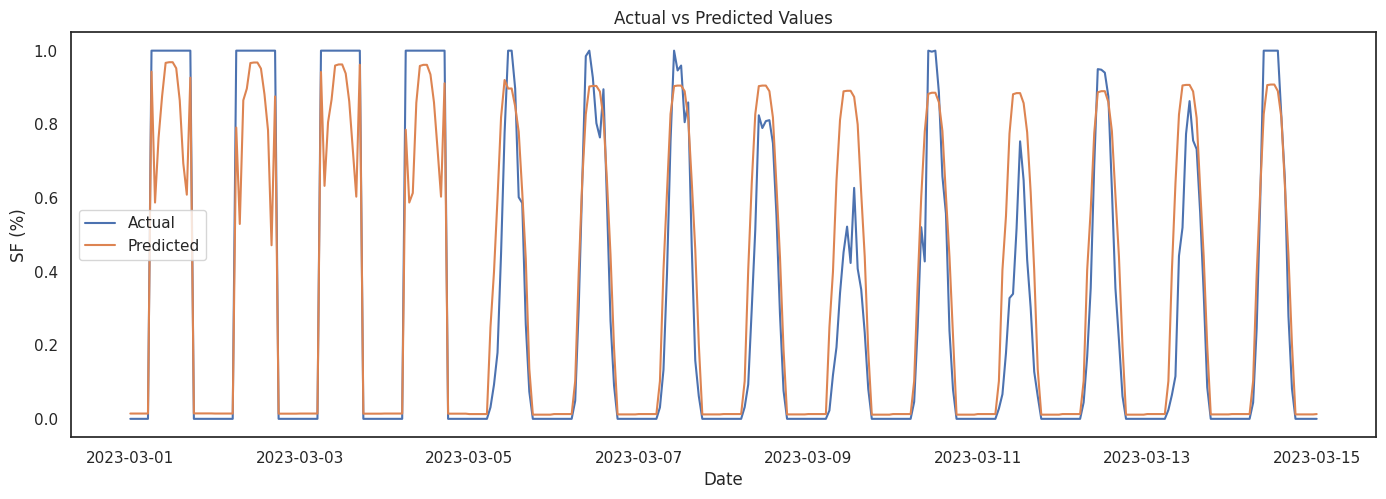

Mean Squared Error (MSE): 0.0232
Root Mean Squared Error (RMSE): 0.1524
Mean Absolute Error (MAE): 0.0910
R-squared (R2): 0.8613


In [161]:
def compare_actual_vs_predicted(df_original, reg, start_date, end_date):
    """
    Compares actual and predicted values within a specified time range.

    Args:
        df_original (pd.DataFrame): The original DataFrame containing the actual data.
        reg (xgb.XGBRegressor): The trained XGBoost model.
        start_date (str): Start date in the format 'YYYY-MM-DD'.
        end_date (str): End date in the format 'YYYY-MM-DD'.
    """
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # Import necessary functions

    # Filter the original DataFrame for the specified time range
    df_filtered = df_original[(df_original.index >= start_date) & (df_original.index <= end_date)]

    # Create features for the filtered data
    df_filtered = create_features(df_filtered)  # Assuming create_features is defined

    # Prepare features for prediction
    X_filtered = df_filtered[FEATURES]  # Assuming FEATURES is defined

    # Make predictions using the trained model
    predictions = reg.predict(X_filtered)

    # Add predictions to the filtered DataFrame
    df_filtered['Prediction'] = predictions

    # Plot actual vs predicted values
    plt.figure(figsize=(15, 5))
    plt.plot(df_filtered.index, df_filtered['SF (%)'], label='Actual')
    plt.plot(df_filtered.index, df_filtered['Prediction'], label='Predicted')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Date')
    plt.ylabel('SF (%)')
    plt.legend()
    plt.show()

    # Calculate metrics
    mse = mean_squared_error(df_filtered['SF (%)'], df_filtered['Prediction'])
    rmse = np.sqrt(mean_squared_error(df_filtered['SF (%)'], df_filtered['Prediction']))  # Calculate RMSE using np.sqrt
    mae = mean_absolute_error(df_filtered['SF (%)'], df_filtered['Prediction'])
    r2 = r2_score(df_filtered['SF (%)'], df_filtered['Prediction'])

    # Print metrics
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2): {r2:.4f}")

    return df_filtered  # Return the DataFrame with predictions

# Example usage:
start_date = '2023-03-01'
end_date = '2023-03-15'
df_with_predictions = compare_actual_vs_predicted(df_xgb, reg, start_date, end_date)

In [162]:
df_xgb.index.max()

Timestamp('2023-12-31 23:00:00')

In [163]:
# Create future dataframe
future = pd.date_range('2023-12-31','2025-12-31', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df_xgb['isFuture'] = False
df_and_future = pd.concat([df_xgb, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [164]:
future_w_features = df_and_future.query('isFuture').copy()

##Predict the future

In [165]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

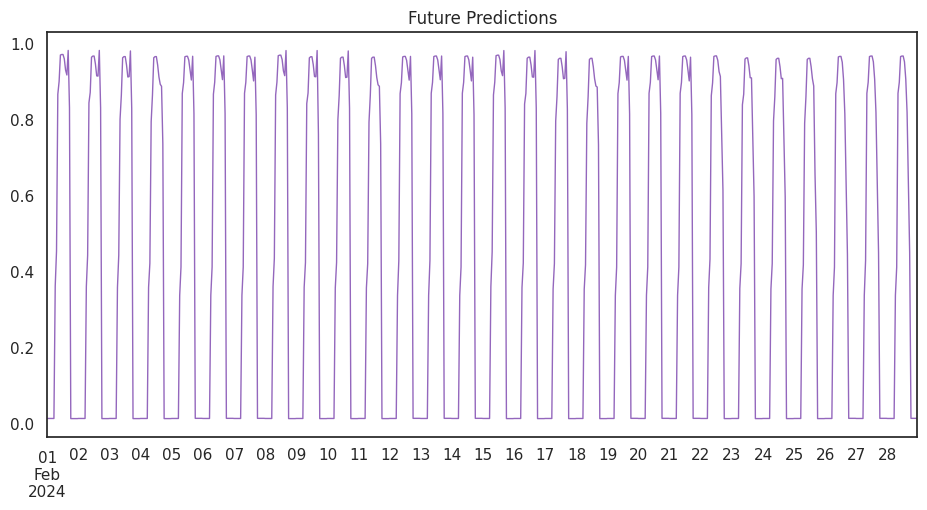

In [166]:
future_w_features_filtered = future_w_features['pred'].loc['2024-02-01':'2024-02-28']

future_w_features_filtered.plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()